# PROJECT-3. EDA + Feature Engineering

## 1. Введение

### В РЕЗУЛЬТАТЕ РАБОТЫ НАД ДАННЫМ ПРОЕКТОМ МЫ:


✔️ создадим свою первую модель, основанную на алгоритмах машинного обучения;

✔️ примем участие в соревновании на [Kaggle](https://www.kaggle.com/);

✔️ поймём, как правильно «подготовить» данные, чтобы ваша модель работала лучше.

### ЧЕМ МЫ БУДЕМ ЗАНИМАТЬСЯ?

В этом модуле вы попробуете решить свой первый настоящий кейс и создадите первую модель, использующую алгоритмы машинного обучения.

Скоро вы убедитесь не только в теории, но и на практике, что тщательная очистка данных, проектирование признаков и разведывательный анализ данных способны повысить точность модели в два и более раз, и владение этими навыками играет в машинном обучении не меньшую роль, чем умение выбрать алгоритм и настроить модель.

Итак, вы создадите свою первую модель, а после этого используете свои навыки для участия в соревновании на платформе Kaggle.

### КАКОЙ КЕЙС РЕШАЕМ?

Представьте, что вы работаете дата-сайентистом в компании Booking. Одна из проблем компании — это нечестные отели, которые накручивают себе рейтинг. Одним из способов обнаружения таких отелей является построение модели, которая предсказывает рейтинг отеля. Если предсказания модели сильно отличаются от фактического результата, то, возможно, отель ведёт себя нечестно, и его стоит проверить.

Вам поставлена задача создать такую модель. Готовы приступить?

## 2. Разбираемся с данными

✍ В этом модуле вы будете работать с [датасетом](https://drive.google.com/uc?id=1ikv9SwqRQztgRwI42RNXWNsMzpEtx16Y), в котором содержатся сведения о 515 000 отзывов на отели Европы. Модель, которую вы будете обучать, должна предсказывать рейтинг отеля по данным сайта Booking на основе имеющихся в датасете данных. Изученные нами навыки разведывательного анализа помогут улучшить модель.

**Примечание.** Для загрузки в локальный репозиторий воспользуйтесь командой: gdown 'https://drive.google.com/uc?id=1ikv9SwqRQztgRwI42RNXWNsMzpEtx16Y'

In [1]:
# импортируем библиотеки
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', None)
 # Сброс ограничений на число столбцов
pd.set_option('display.max_columns', None)
 # Сброс ограничений на количество символов в записи
pd.set_option('display.max_colwidth', None)

from selenium.webdriver import Chrome
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait as wait
from selenium.webdriver.support import expected_conditions as EC 
from selenium.common.exceptions import NoSuchElementException
from bs4 import BeautifulSoup
from time import sleep
from tqdm import tqdm
from selenium import webdriver
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time
import seaborn as sns
import matplotlib.pyplot as plt #для визуализации
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from datetime import date
import category_encoders as ce

In [5]:
# прочитаем файл тренировочной выборки
hotels_data_train = pd.read_csv(r'hotels_train.csv.zip')
hotels_train = hotels_data_train.copy()
hotels_train.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough London W1J 8LT United Kingdom,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ', ' Stayed 2 nights ', ' Submitted from a mobile device ']",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF United Kingdom,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Double Room ', ' Stayed 1 night ']",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern Double Room Echo ', ' Stayed 3 nights ', ' Submitted from a mobile device ']",289 day,48.845377,2.325643


Первоначальная версия датасета содержит 17 полей со следующей информацией:

- *hotel_address* — адрес отеля;
- *review_date* — дата, когда рецензент разместил соответствующий отзыв;
- *average_score* — средний балл отеля, рассчитанный на основе последнего комментария за последний год;
- *hotel_name* — название отеля;
- *reviewer_nationality* — страна рецензента;
- *negative_review*— отрицательный отзыв, который рецензент дал отелю;
- *review_total_negative_word_counts* — общее количество слов в отрицательном отзыве;
- *positive_review* — положительный отзыв, который рецензент дал отелю;
- *review_total_positive_word_counts* — общее количество слов в положительном отзыве.
- *reviewer_score* — оценка, которую рецензент поставил отелю на основе своего опыта;
- *total_number_of_reviews_reviewer_has_given* — количество отзывов, которые рецензенты дали в прошлом;
- *total_number_of_reviews* — общее количество действительных отзывов об отеле;
- *tags* — теги, которые рецензент дал отелю;
- *days_since_review* — количество дней между датой проверки и датой очистки;
- *additional_number_of_scoring* — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
- *lat* — географическая широта отеля;
- *lng* — географическая долгота отеля.

**Примечание.** Для загрузки в локальный репозиторий воспользуйтесь командой: gdown 'https://drive.google.com/uc?id=1sN-Tlrrvf5_V-jGx22rV1hLIou9Tq4Ri'

In [6]:
# прочитаем файл тренировочной выборки
hotels_data_test = pd.read_csv(r'hotels_test.csv.zip')
hotels_test = hotels_data_test.copy()
hotels_test.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel that sold drinking water etc but not necessity Would recommend if like us you arrive late at night to bring drinks from plane airport as there s no shop nearby There is a minibar though if you want to pay those prices,52,16670,Hotel was great clean friendly staff free breakfast every morning with good selection good wifi connection nice sized room with bath fridge in room Personally loved the fact that the hotel isn t in the city centre but is literally next to a train station that you can easily get to and from the airport city Would definitely stay again,62,1,"[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 2 nights ']",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Netherlands,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ', ' Stayed 1 night ']",234 day,52.385649,4.834443
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']",616 day,41.393192,2.161520


**Примечание.** Для загрузки в локальный репозиторий воспользуйтесь командой: gdown 'https://drive.google.com/uc?id=13yYjKvIYLJ618-vGYuD1nImsoSMy6BNi'

In [7]:
# образец сабмишен
sample_submission = pd.read_csv(r'submission.csv.zip')
sample_submission.head()

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596


In [7]:
# получим информацию по датасету
hotels_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [8]:
hotels_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

Тренировочный датасет состоит из 386803 строк и 17 столбцов, в двух столбцах имеются пропущенные значения: lat — географическая широта отеля и  lng — географическая долгота отеля. девять столбцов представлены в виже числовых данных в форматах float64(4 столбца), int64(5 столбцов), остальные 8 столбцов в формате object.
Тестовый датасет состоит 128935 из строк и 16 столбцов(без целевого).

## 3. Машинное обучение

### 1. РАЗДЕЛЕНИЕ НАБОРА ДАННЫХ

Прежде всего, для создания модели необходимо разделить датафрейм на набор данных, которые мы будем использовать для обучения модели, именуемый X, и на целевую переменную — величину, значение которой мы будем предсказывать, y(в нашем случае это рейтинг отелей).

![An](https://lms.skillfactory.ru/assets/courseware/v1/2962190377a2a4c55ae3f6b5643f1ccc/asset-v1:SkillFactory+DSPR-2.0+14JULY2021+type@asset+block/dst3-u2-pr3_3_1.png)


Далее каждый из полученных наборов мы делим на **тренировочный** (**train**, используется для обучения модели) и **тестовый** (**test**, используется для оценки точности модели). Такое деление осуществляется с помощью специального метода [train_test_split()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) библиотеки **sklearn**. В параметрах метода (параметр **test_size**) мы указываем, какую часть исходного датафрейма нужно оставить для тестирования модели. В нашем коде эта часть составляет 25 %, или 0.25.

Не существует идеального соотношения обучающей и тестовой выборки, однако принято выделять на часть обучения больше данных, около ⅔, а оставшуюся часть используют для проверки — ⅓ выборки. Таким образом, самые популярные значения параметра **test_size** составляют 0.3, 0.25, 0.2.

In [9]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# X_tr- данные с информацией об отелях, y_tr - целевая переменная (рейтинги отелей)  
X_tr = hotels_train.drop(['reviewer_score'], axis = 1)
y_tr = hotels_train['reviewer_score']

In [10]:
# Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split  

In [11]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train_tr, X_test_tr, y_train_tr, y_test_tr = train_test_split(X_tr, y_tr, test_size=0.25, random_state=42)

### 2. СОЗДАНИЕ И ОБУЧЕНИЕ МОДЕЛИ

Сам процесс создания и тестирования модели занимает всего четыре строчки кода. В качестве алгоритма мы будем использовать популярный и довольно мощный алгоритм [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html). Он реализован в библиотеке sklearn.

Для корректной работы все данные в датафрейме, который мы будем использовать при обучении модели, должны быть в числовых форматах int или float. 

Есть ещё одно ограничение: в столбцах не должно быть пропущенных значений. Вместо каждого пропущенного значения нам нужно будет вычислить и поместить в ячейку максимально близкое к реальности значение.

→ Таким образом, чтобы код, отвечающий за обучение модели, заработал, мы должны использовать в нём датафрейм, содержащий только количественные признаки и не содержащий пропущенных значений.

На первом этапе для создания такого датафрейма давайте просто удалим столбцы, содержащие данные типов object и string и заполним пропущенные значения каким-то одним значением (unknown, нулём или средним арифметическим) для всего столбца.

In [10]:
object_columns_train = [s for s in X_train_tr.columns if X_train_tr[s].dtypes == 'object']
object_columns_test = [s for s in X_test_tr.columns if X_test_tr[s].dtypes == 'object']
X_train_tr = X_train_tr.drop(object_columns_train, axis = 1).fillna(0)
X_test_tr = X_test_tr.drop(object_columns_test, axis = 1).fillna(0)
# Сразу сформируем тестовый набор для сабмита
X_test_ts = hotels_test.drop(object_columns_train, axis = 1).fillna(0)

In [11]:
# Импортируем необходимые библиотеки:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  
  
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100, random_state=42)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train_tr, y_train_tr)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test_tr)
# предсказания для сабмита
y_pred_test = regr.predict(X_test_ts)

### 3. ОЦЕНКА КАЧЕСТВА МОДЕЛИ

Для оценки качества модели — точности прогнозов, сделанных моделью, — мы будем использовать метрику (некий числовой показатель), которая называется **MAPE** (mean absolute percentage error), средняя абсолютная процентная ошибка. Эту метрику очень легко интерпретировать. Если у вас MAPE = 11.4 %, то это говорит о том, что ошибка составила 11.4 % от фактических значений.

$MAPE = 100 \% * 1/n \sum_{i=1}^{n} \frac{\left| ytrue_{i} - ypred_{i} \right|}{\left| ytrue_{i} \right|}$,

где $ytrue_{i}$ — фактические значения прогноза, a $ypred_{i}$ — предсказанные.

Для расчета MAPE сравним предсказанные нашей моделью значения с реальными и посмотрим на значение ошибки. 

In [13]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print(f'MAPE:{metrics.mean_absolute_percentage_error(y_test_tr, y_pred):.4f}') 

MAPE:0.1414


In [26]:
# сформируем первый сабмишен
sample_submission['reviewer_score'] = y_pred_test
sample_submission.to_csv('first_submission.csv', index=False)

Сабмишен показал результат Score: 14.18203

## 4. Лучший способ добиться успеха — следовать советам

✍ Что делать дальше?

Повысить точность прогнозов, которые делает модель, с помощью более тщательной подготовки данных.

При подготовке датасета необходимо будет вспомнить все шаги, которые мы проделывали в модулях EDA. Нам нужно будет не только избавиться от пропущенных значений и нечисловых признаков, но и спроектировать новые признаки на основе информации, уже содержащейся в данных, или используя внешние источники данных, если это возможно. Также мы закодируем и преобразуем признаки, а после отберём лучшие из них.

Задачу, которая стоит перед нами, можно свести к пяти пунктам:

- *Удаление строковых значений.* Вам необходимо удалить из набора данных столбцы, данные в которых представлены не числами.
- *Очистка от пропущенных значений.* На предыдущем шаге мы делали это самым грубым из всех возможных способов, сейчас попробуйте подойти к процессу более гибко.
- *Создание новых признаков.* Мы попробуем создать новые столбцы с данными из существующих данных или с использованием внешних источников.
- *Преобразование признаков.* Применим различные преобразования над признаками вроде нормализации, стандартизации.
- *Отбор признаков.* Используем анализ мультиколлинеарности как шаг отбора признаков для модели.

Наша задача — при помощи этих шагов и рекомендаций повысить качество предсказания. Чтобы понять, что качество улучшилось, ориентируйтесь на метрику MAPE: чем она меньше, тем лучше. Рассмотрим шаги подробнее.

**СТРОКОВЫЕ ДАННЫЕ**

В исходном наборе данных всего девять столбцов содержат числовые данные. Так что просто удалить все object-значения и считать задачу выполненной не получится. Мы сделали это в прошлом юните, чтобы получить значение метрики. Но чтобы улучшить качество модели, вам перед удалением придётся очень основательно поработать со строковыми данными и извлечь из них как можно больше информации, которую можно представить в числовом виде.

**ПРОПУЩЕННЫЕ ЗНАЧЕНИЯ**

Мы уже говорили о том, что в задачах по машинному обучению принято не удалять строки с пустыми значениями, а заполнять их максимально близкими к реальности данными. 

**НОВЫЕ ПРИЗНАКИ**

Это, пожалуй, самая творческая часть работы на данном шаге. Создание новых признаков потребует от вас способности вникать в контент, умения подключать к работе интуицию, творческого подхода и готовности к экспериментам. Попробуйте извлечь несколько признаков из даты, проанализируйте датасет на возможность добавления внешних источников данных. При наличии времени разберите текстовые столбцы на признаки.

**ПРЕОБРАЗОВАНИЕ ПРИЗНАКОВ**

Данные могут быть представлены в невыгодном для модели свете. Используйте изученные вами способы преобразования данных, чтобы сделать данные качественнее.

**ОТБОР ПРИЗНАКОВ**

Признаки могут дублировать информацию. Анализ мультиколлинеарности мы будем использовать, чтобы выбрать уникальные признаки для модели.

Также перед обучением (после разделения выборки на X и y) мы можем оценить значимость каждого признака для целевой переменной — рейтинг отеля. При помощи теста мы сможем узнать, как географическая долгота отеля и количество негативных отзывов влияют на его рейтинг.

Для оценки значимости категориальных признаков будем использовать тест хи-квадрат, для непрерывных признаков — тест ANOVA.

**СОЗДАНИЕ НОВЫХ ПРИЗНАКОВ И ЗАПОЛНЕНИЕ ПРОПУЩЕННЫХ ЗНАЧЕНИЙ**

In [12]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
hotels_train['sample'] = 1 # помечаем где у нас трейн
hotels_test['sample'] = 0 # помечаем где у нас тест
hotels_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

hotels = pd.concat([hotels_train, hotels_test], axis=0, ignore_index=True)#.reset_index(drop=True) # объединяем
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

In [13]:
# преобразуем признак review_date в формат datetime
hotels['review_date'] = pd.to_datetime(hotels['review_date'])
# выделим из адреса отеля страну и город и создадим новые признаки
hotels['hotel_address_country'] = hotels['hotel_address'].apply(lambda x: x.split(' ')[-1])
hotels['hotel_address_country'] = hotels['hotel_address_country'].apply(lambda x: 'United Kingdom' if x == 'Kingdom' else x)
hotels['hotel_address_city'] = hotels['hotel_address'].apply(lambda x: x.split(' ')[-5] if x.split(' ')[-1]=='Kingdom' else x.split(' ')[-2] )
# обработаем days_since_review выделив количество дней, преобразуем в числовой признак
hotels['days_since_review'] = hotels['days_since_review'].apply(lambda x: int(x.split(' ')[0]))

In [15]:
# создадим новый бинарный признак из reviewer_nationality и hotel_address_country -  он будет показывать является ли рецензент резидентом данной страны, либо прибыл из других стран
def resident(address_country, nationality):
    """ Возвращает бинарный признак резидентности рецензента
    1 - резидент, 0 - нерезидент
    Args:
        address_country (object): страна отеля
        nationality (object): страна рецензента
    Returns:
        norm: int64
    """
    nationality = nationality.split(' ')
    
    if nationality[-2]=='Kingdom':
        nationality = ''.join([nationality[1], ' ', nationality[2]])
        if address_country == nationality:
            return 1
        else:
            return 0
    else:
        if address_country == nationality[1]:
            return 1
        else:
            return 0
hotels['resident'] = hotels.apply(lambda x: resident(x.hotel_address_country, x.reviewer_nationality), axis=1)    

**ПРОПУЩЕННЫЕ ЗНАЧЕНИЯ**

Ранее определили, что пропущенные значения имеются в двух столбцах координат - 'lat' и 'lng'. Заполним пропуски средним значением координат соответствующего города.

In [16]:
# составляем словари, где ключи название городов, значения - средние значение координаты по городу
city_lat = dict(hotels.groupby(['hotel_address_city'])['lat'].mean())
city_lng = dict(hotels.groupby(['hotel_address_city'])['lng'].mean())

def change(city, coordinate):
    """Заменяет пропуски в координате и возвращает 
    среднее значение координаты по конкретному городу

    Args:
        city (object): город, где находится гостиница
        coordinate (float64): соответствующая координата -  lat(широта) или lng(длина)

    Returns:
        float64: среднее значение координаты по городу
    """
    if str(coordinate) == 'nan':
        coordinate = city_lat[city]
        return coordinate
    else:
        return coordinate
# заполняем пропуски
hotels['lat'] = hotels.apply(lambda x: change(x.hotel_address_city, x.lat), axis=1)
hotels['lng'] = hotels.apply(lambda x: change(x.hotel_address_city, x.lng), axis=1)

Создадим новый признак из внешних источников - это звёздность гостиниц - как фактор напрямую влияющий на впечатления рецензента -  в нём зашиты определённые требования к гостиницам, а значит и уровень сервиса.

Для начала создадим новый признак 'hotels_name_full' -  который объединит наименование отеля(признак 'hotel_name') и адресс отеля(признак 'hotel_address'). Делаем это для того чтобы парсер искал отель не только по наименованию так как могут несколько отелей с одинаковым названием, но расположенные в разных городах/странах, поэтому искать будем с уточнением месторасположения.
Парсить будем с помощью библиотеки [Selenium](https://www.selenium.dev/).

Идея такая - напишем парсер, который будет переходить на поисковик Яндекс(https://yandex.ru/) - далее брать поочерёдно информацию(реализуем с помощью цикла) с признака 'hotels_name_full'(для этого сначала сформируем список из уникальных отелей) - вставлять в строку поиска - подтвержать ввод - далее на странице с результатами поиска забрать необходиму информацию, обработать и положить в заранее созданный словарь(по ключу - наименование отеля с адресом, по значению - звёздность отеля).

In [17]:
# создаём новый признак 'hotels_name_full' с наименование отеля и адрессом
hotels['hotels_name_full'] = hotels['hotel_name'] + ' ' + (hotels['hotel_address'])

In [15]:
""" 
# формируем список отелей с уникальными названиями
hotels_unique = list(hotels['hotels_name_full'].unique())
# счётчик итераций
check = 0
# создаём пустой словарь
stars_dict = stars_dict_1
# формируем цикл для перебора отелей
for hotel in hotels_unique:
    # создаём объект драйвер для открытия страниц в браузере
    driver = webdriver.Chrome()
    # ссылка сайта для парсинга
    url = 'https://yandex.ru/'
    # передаём адрес в драйвер
    driver.get(url)
    # находим окно поиска
    driver.find_element_by_xpath('//*[@id="text"]')
    input_tab = driver.find_element_by_xpath('//*[@id="text"]')
    # вставляем в поисковик название отеля
    input_tab.send_keys(hotel)
    # подтверждение ENTER
    input_tab.send_keys(Keys.ENTER)
    sleep(1)
    # обрабатываем исключения
    try:
        # сохраяем необходимую информацию в переменную info
        info = driver.find_element_by_xpath('//*[@id="search-result-aside"]/div[1]/div/div/div[1]/div/div[1]/div[1]/span')
    except NoSuchElementException:
        try:
            info = driver.find_element_by_xpath('//*[@id="search-result-aside"]/div[1]/div/div/div[1]/div/div[1]/div[1]/div/span[1]')
        except NoSuchElementException:
            continue
    # обрабатываем полученные данные    
    stars = list(info.text.split(' '))[-1].split('*')[0]
    # добавляем информацию в словарь
    stars_dict[hotel] = stars
    # закрываем страницу
    driver.close()
    sleep(1)
    check += 1
    # после каждой итерации выводится порядковый номер итерации
    print(check)
# сохраним сам словарь в файл, для того, чтобы не парсить сайт для получения инфы, а уже пользоваться готовым словарём
np.save('stars_dict.npy', stars_dict) """

' \n# формируем список отелей с уникальными названиями\nhotels_unique = list(hotels[\'hotels_name_full\'].unique())\n# счётчик итераций\ncheck = 0\n# создаём пустой словарь\nstars_dict = stars_dict_1\n# формируем цикл для перебора отелей\nfor hotel in hotels_unique:\n    # создаём объект драйвер для открытия страниц в браузере\n    driver = webdriver.Chrome()\n    # ссылка сайта для парсинга\n    url = \'https://yandex.ru/\'\n    # передаём адрес в драйвер\n    driver.get(url)\n    # находим окно поиска\n    driver.find_element_by_xpath(\'//*[@id="text"]\')\n    input_tab = driver.find_element_by_xpath(\'//*[@id="text"]\')\n    # вставляем в поисковик название отеля\n    input_tab.send_keys(hotel)\n    # подтверждение ENTER\n    input_tab.send_keys(Keys.ENTER)\n    sleep(1)\n    # обрабатываем исключения\n    try:\n        # сохраяем необходимую информацию в переменную info\n        info = driver.find_element_by_xpath(\'//*[@id="search-result-aside"]/div[1]/div/div/div[1]/div/div[1]/di

In [18]:
# загрузить уже готовый словарь, ранее спарсенный
stars_dict = np.load('stars_dict.npy', allow_pickle=True).item()

**Примечание**. Для загрузки в локальный репозиторий воспользуйтесь командой: gdown 'https://drive.google.com/uc?id=1w-x20v5ZjVeBlgJ5CFhY40cwIF4xPpbK'

In [19]:
def get_stars_hotels(hotels_name_full, stars_dict):
    """ Возвращает информацию о звёздности отеля

    Args:
        hotels_name_full (object_): наименование отеля с адресом
        stars_dict (dictionary): словарь справочник с данными(ключ - наименование отеля, 
        значение - звёздность отеля)

    Returns:
        int: количество звёзд отеля
    """
    star_list = ['1', '2', '3', '4', '5']
    if hotels_name_full in stars_dict.keys():
        star = stars_dict[hotels_name_full]
        if star in star_list:
            star = int(star)
            return star
        else:
            return 0
    else:
        return 0       

In [20]:
# создаём новый признак звёздости в датасете
hotels['stars'] = hotels.apply(lambda x: get_stars_hotels(x.hotels_name_full, stars_dict), axis=1)

In [21]:
hotels[hotels['stars'] != 0].describe()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,days_since_review,lat,lng,sample,resident,stars
count,481912.000000,481912.000000,481912.000000,481912.000000,481912.000000,481912.000000,481912.000000,481912.000000,481912.000000,481912.000000,481912.000000,481912.000000,481912.000000
mean,498.851228,8.396645,18.562640,2739.212736,17.743142,7.156834,6.294512,353.796728,49.415905,3.112379,0.749683,0.346978,4.049625
std,510.523586,0.548849,29.712103,2328.693495,21.736491,11.007603,3.903553,208.922653,3.473899,5.863329,0.433196,0.476009,0.522459
min,1.000000,6.400000,0.000000,43.000000,0.000000,1.000000,0.000000,0.000000,41.328376,-0.369758,0.000000,0.000000,1.000000
25%,169.000000,8.100000,2.000000,1161.000000,5.000000,1.000000,0.000000,174.000000,48.213061,-0.142745,0.000000,0.000000,4.000000
50%,335.000000,8.400000,9.000000,2085.000000,11.000000,3.000000,7.900000,352.000000,51.499981,0.019886,1.000000,0.000000,4.000000
75%,639.000000,8.800000,23.000000,3633.000000,22.000000,8.000000,9.600000,527.000000,51.516129,4.834975,1.000000,1.000000,4.000000
max,2682.000000,9.800000,408.000000,16670.000000,395.000000,355.000000,10.000000,730.000000,52.400181,48.863715,1.000000,1.000000,5.000000


Заменим ненайденные значения по звёздности на среднюю - 4 звезды.

In [22]:
hotels['stars'] = hotels['stars'].apply(lambda x: 4 if x == 0 else x)

Попробуем создать новый признак определяющий долю туристов, поставившие оценку(additional_number_of_scoring), но не оставившие отзыв, от общего числа туристов оставивших отзыв. 

In [23]:
hotels['score without reviews'] = round(hotels['additional_number_of_scoring'] / hotels['total_number_of_reviews'], 2)

Обработаем признак tags, для этого сначала создадим функцию tags_info очистки от лишних символов.

In [24]:
def tags_info(tags):
    """Обрабатывает признак преобразуя из строкового значения в лист
    удаляя ненужных символы

    Args:
        tags (object): строка с набором тэгов

    Returns:
        object: лист с разделёнными тэгами и очищенный от ненужных символов
    """
    number = ['0', '1,' '2', '3', '4', '5', '6', '7', '8', '9', '0']
    for mot in tags:
        if mot.isalpha() is False and mot != ' ' and mot != ',' and mot not in number:
            tags = tags.replace(mot, '')
    tags = tags.split(',')
    return tags

In [25]:
# применим функцию tags_info к нашему признаку
hotels['tags'] = hotels['tags'].apply(tags_info)

На основе признака 'tags' создадим ещё пять признаков. Если проанализировать содержание тэга, то видим, что на первом месте идёт цель поездки(на его основе создадим признак purpose of the trip), на втором месте - турист останавливался один в отеле или нет(новый признак назовём form of recreation), на третьем месте категория номера(новый признак room category), на четвёртом месте информация о количестве ночей(новый признак назовём count_night), на пятом месте стоит информация о том каким образом был оставлен отзыв(новый признак device).

In [26]:
# цель поездки
hotels['purpose of the trip'] = hotels['tags'].apply(lambda x: x[0].strip(' '))
# останавливается один или нет
hotels['form of recreation'] = hotels['tags'].apply(lambda x: x[1].strip(' ') if len(x)>2 else 0)
# категория номера
hotels['room category'] = hotels['tags'].apply(lambda x: x[2].strip(' ') if len(x)>3 else 0)
# количество ночей
hotels['count_night'] = hotels['tags'].apply(lambda x: x[3].strip(' ') if len(x)>=4 else 0)
# дообработка признаков
hotels['purpose of the trip'] = hotels['purpose of the trip'].apply(lambda x: x if x in ['Leisure trip', 'Business trip'] else 'Leisure trip')
hotels['form of recreation'] = hotels['form of recreation'].apply(lambda x: x if x in ['Couple', 'Solo traveler', 'Group', 'Family with young children', 'Family with older children', 'Travelers with friends']
                                                                  else 'Couple')
hotels['room category'] = hotels['room category'].apply(lambda x: 'Double Room' if x ==0 else x)

dict_room = {}
def get_room(room):
    """счётчик категорий по данному признаку, 
    формирует словарь -  категория:кол-во

    Args:
        room (any): категория
    """
    n = 1
    if room not in dict_room.keys():
        dict_room.update({room:n})
    else:
        dict_room[room] = dict_room[room]+1
# считаем количество категорий по признаку room category, данные сохранены в словарь dict_room
hotels['room category'].apply(get_room)
# в признаке room category, если признак встречается редко(<1000), то заменяем на 'other'    
hotels['room category'] = hotels['room category'].apply(lambda x: x if dict_room[x]>1000 else 'other')

# создадим словарь ночей
night = {'Stayed  night': 1, 'Stayed  nights': 2, 'Stayed 3 nights': 3, 'Stayed 4 nights': 4, 'Stayed 5 nights': 5,
         'Stayed 6 nights' : 6, 'Stayed 7 nights' : 7, 'Stayed 8 nights': 8, 'Stayed 9 nights' : 9}
# создадим новый признак count_night
hotels['count_night'] = hotels['count_night'].apply(lambda x: night[x] if x in night.keys() else 1)

# создаём признак device показывающий через какое устройство был оставлен отзыв и обрабатываем
hotels['device'] = hotels['tags'].apply(lambda x: x[-1].strip(' '))
hotels['device']= hotels['device'].apply(lambda x: x if x == 'Submitted from a mobile device' else 'Computer')
hotels['device'] = hotels['device'].apply(lambda x:1 if x == 'Submitted from a mobile device' else 0)

# обработаем признак review_date как период, отражающий кол-во дней - разницы между сегодняшним днём и даты отзыва
today = date.today()
hotels['review_date'] = (pd.to_datetime(today) - hotels['review_date']).dt.days

В признаках 'review_total_negative_word_counts'/'review_total_positive_word_counts' количество слов в отзыве не соотвествует значению соответсвующих столбцов 'negative_review'/'positive_review', поэтому исправим это:

In [27]:
hotels['review_total_negative_word_counts'] = hotels['negative_review'].apply(lambda x:len(x.split()))
hotels['review_total_positive_word_counts'] = hotels['positive_review'].apply(lambda x:len(x.split()))

Обработаем сам текст комментариев, для этого используем библиотеку обработки естесвенного языка [nltk](https://www.nltk.org/)

In [28]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time
nltk.downloader.download('vader_lexicon')
sent_analyzer = SentimentIntensityAnalyzer()

def nltk_rewiew(rewiew):
    """Анализатор чувств 

    Args:
        rewiew (object): строка с отзывом

    Returns:
        dict: словарь, где ключами являются 'neg'(негативный),
        'neu'(нейтральный), 'pos'(позитивный), 'compound'(оценивает эмоции), а значениями являются: 
        Первые три представляют процент оценок настроений для каждой категории в нашем заголовке, а 'compound' - 
        число, которое оценивает эмоции. составной диапазон составляет от -1 (крайне отрицательный) до 1 (крайне положительный)
    """
    rk_rewiew = sent_analyzer.polarity_scores(rewiew)
    return rk_rewiew

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Антон\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [29]:
# создадим новые признаки анализаторы чувств
hotels['neg_negative_review'] = hotels['negative_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['neg'])
hotels['neu_negative_review'] = hotels['negative_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['neu'])
hotels['pos_negative_review'] = hotels['negative_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['pos'])
hotels['compound_negative_review'] = hotels['negative_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['compound'])

hotels['neg_positive_review'] = hotels['positive_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['neg'])
hotels['neu_positive_review'] = hotels['positive_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['neu'])
hotels['pos_positive_review'] = hotels['positive_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['pos'])
hotels['compound_positive_review'] = hotels['positive_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['compound'])

In [30]:
# удаляем столбцы, которые больше не пригодятся
hotels = hotels.drop(columns=['hotel_address', 'tags', 'positive_review', 'negative_review', 'hotels_name_full', 'hotel_name'], axis=1)
# после обработки общего файла разделяем их обратно на тренировочный и тестовый, удаляя ранее созданный признак sample
hotels_train_clean = hotels[hotels['sample']==1].drop('sample', axis=1)
hotels_test_clean = hotels[hotels['sample']==0].drop('sample', axis=1)

<AxesSubplot:>

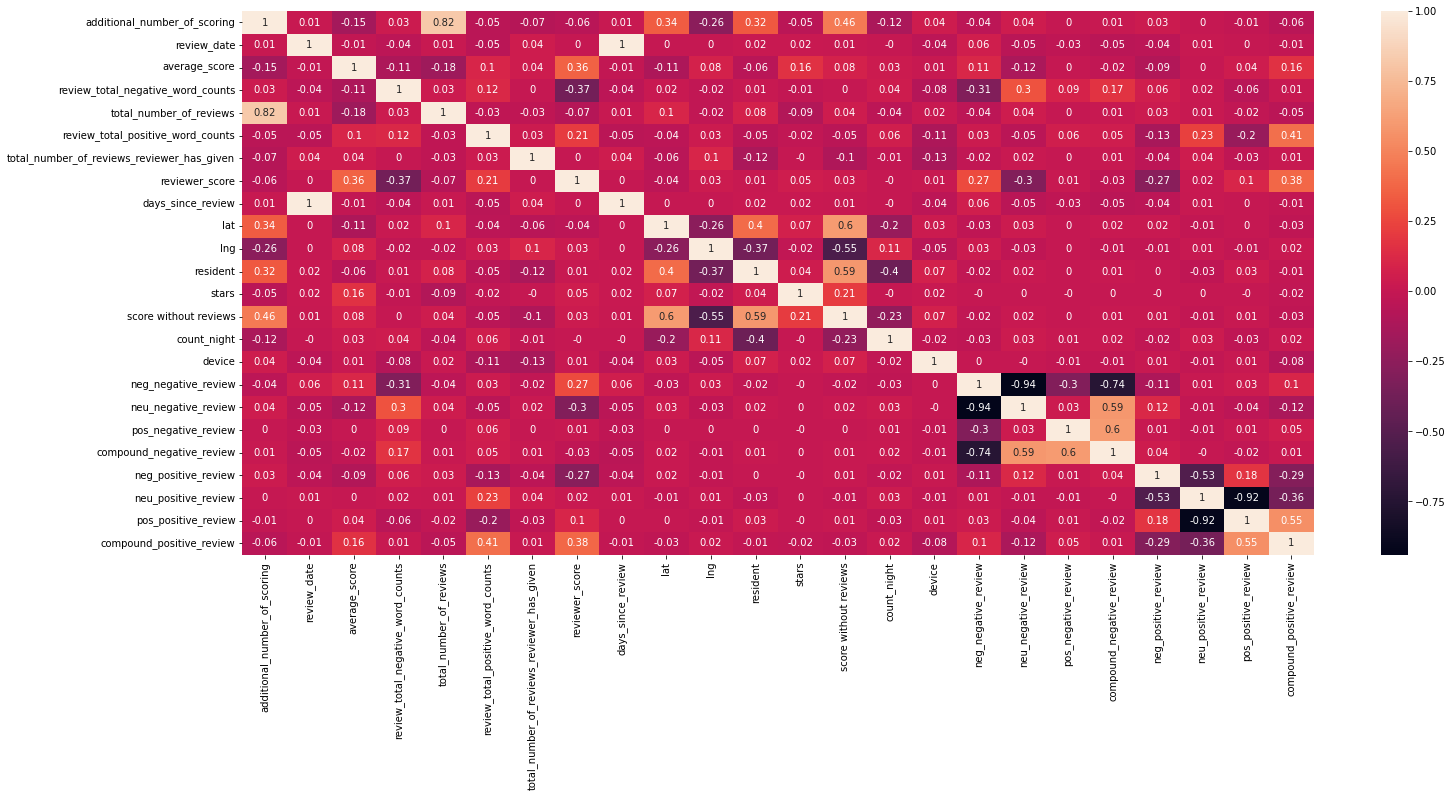

In [31]:
# строим матрицу корреляции
fig, axes = plt.subplots(figsize=(24, 10))
sns.heatmap(round(hotels_train_clean.corr(), 2), annot = True)

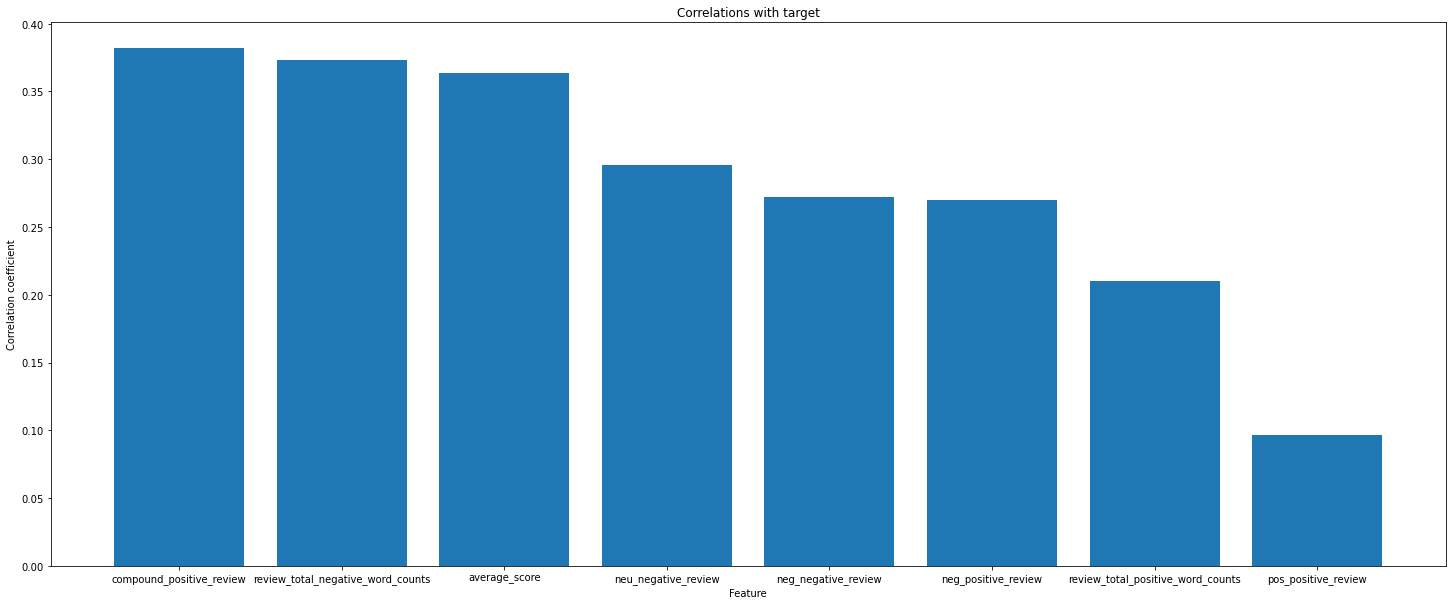

In [41]:
#Вычисляем модуль корреляции
corr_with_target = hotels_train_clean.corr()['reviewer_score'].abs().sort_values(ascending=False)[0:9]
#Удаляем корреляцию целевой переменной с самой собой
corr_with_target = corr_with_target.drop('reviewer_score')
#Строим столбчатую диаграмму корреляций
fig, ax = plt.subplots(figsize=(25, 10)) #фигура+координатная плоскость
ax.bar(corr_with_target.index, corr_with_target.values) #столбчатая диаграмма
ax.set_title('Correlations with target') #название графика
ax.set_xlabel('Feature') #название оси x
ax.set_ylabel('Сorrelation coefficient'); #название оси y

Из матрицы видно, что нет признаков мультиколлинеарных с целевым признаком 'review_score'. Наибольшая корелляция с признаками 'compound_positive_review', 'review_total_negative_word_counts', 'average_score', 'neu_negative_review', 'neg_negative_review'.

In [43]:
# выделим в кадом наборе данных списки с признаками типа 'object' для кодирования и дальнейшего удаления
object_columns_train_clean = [s for s in hotels_train_clean.columns if hotels_train_clean[s].dtypes == 'object']
object_columns_test_clean = [s for s in hotels_test_clean.columns if hotels_test_clean[s].dtypes == 'object']

In [44]:
# для кодирования используем бинарное кодирование
bin_encoder_train = ce.BinaryEncoder(cols=object_columns_train_clean) # указываем столбцы для кодирования тренировочной выборки
type_bin_train = bin_encoder_train.fit_transform(hotels_train_clean[object_columns_train_clean])
hotels_train_clean = pd.concat([hotels_train_clean, type_bin_train], axis=1)
# кодирование данных тестовой выборки
bin_encoder_test = ce.BinaryEncoder(cols=object_columns_test_clean) # указываем столбцы для кодирования тестовой выборки
type_bin_test = bin_encoder_test.fit_transform(hotels_test_clean[object_columns_test_clean])
hotels_test_clean = pd.concat([hotels_test_clean, type_bin_test], axis=1)
# удаляем лишние признаки
hotels_train_clean = hotels_train_clean.drop(object_columns_train_clean, axis=1)
hotels_test_clean = hotels_test_clean.drop(object_columns_test_clean, axis=1)
hotels_test_clean = hotels_test_clean.drop('reviewer_score', axis=1)

In [45]:
# производим нормализацию данных
X = hotels_train_clean.drop(['reviewer_score'], axis = 1)
y = hotels_train_clean['reviewer_score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
# инициализируем нормализатор MinMaxScaler
mm_scaler = preprocessing.MinMaxScaler()
mm_scaler.fit(X_train)
X_train = mm_scaler.transform(X_train)
X_test = mm_scaler.transform(X_test)

hotels_test_clean_stand = mm_scaler.transform(hotels_test_clean)

Построим модель на всех признаках:

In [46]:
# Импортируем необходимые библиотеки:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  
  
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100, random_state=42)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)
# предсказания рейтинга для сабмита
y_pred_test = regr.predict(hotels_test_clean_stand)

<AxesSubplot:>

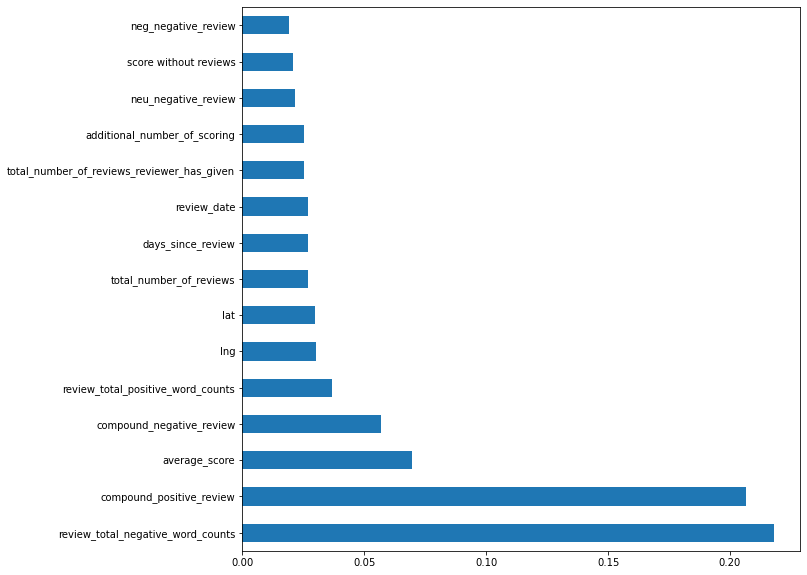

In [50]:
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [47]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print(f'MAPE:{metrics.mean_absolute_percentage_error(y_test, y_pred):.4f}')

MAPE:0.1252


In [48]:
sample_submission['reviewer_score'] = y_pred_test
sample_submission.to_csv('final_submission.csv', index=False)

Оценка сабмишена Score:  12.61461 - 12.61773.

## Вариации на тему

### Вариант 3

Изменения от финального варианта:

добавлена функция **handler_review**, обрабатывающая короткие комментарии - те комментарии, которые состоят из менее, чем 3 слов и которые анализатор чувств в основном обрабатывает как нейтральные, хотя турист хотел выразить своё отрицательное или положительное отношение(в зависимости от **'negative_review'/'positive_review'**). 

Была выдвинута гипотеза, что комментарии обладающие характеристиками выше требуют дополнительной обработки и придание им соответсвующей эмоциональной окраски: если комментарий принадлежит **'negative_review'**, то впереди в комментарии добавляется **'Negative'**, если к **'positive_review'**, то **'Positive'**. После этого необходимо повторно пересчитать данные по признакам **'review_total_negative_word_counts'/'review_total_positive_word_counts'**

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Антон\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


MAPE:0.126


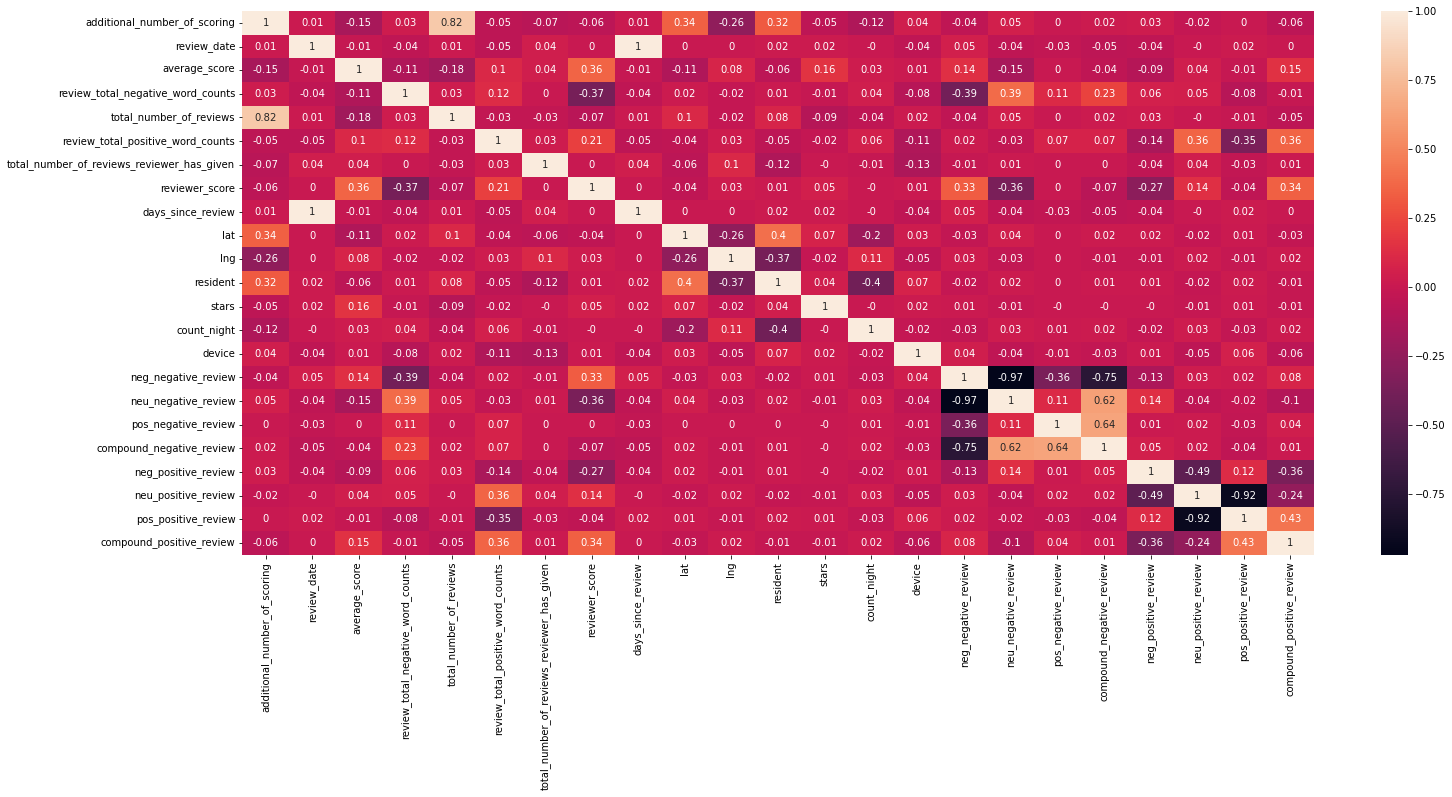

In [37]:
hotels_data_train = pd.read_csv('C:\Python\data\hotels_train.csv')
hotels_train = hotels_data_train.copy()

hotels_data_test = pd.read_csv('C:\Python\data\hotels_test.csv')
hotels_test = hotels_data_test.copy()

sample_submission = pd.read_csv('submission.csv')

# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
hotels_train['sample'] = 1 # помечаем где у нас трейн
hotels_test['sample'] = 0 # помечаем где у нас тест
hotels_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

hotels = pd.concat([hotels_train, hotels_test], axis=0, ignore_index=True)#.reset_index(drop=True) # объединяем

# преобразуем признак review_date в формат datetime
hotels['review_date'] = pd.to_datetime(hotels['review_date'])
# выделим из адреса отеля страну и город и создадим новые признаки
hotels['hotel_address_country'] = hotels['hotel_address'].apply(lambda x: x.split(' ')[-1])
hotels['hotel_address_country'] = hotels['hotel_address_country'].apply(lambda x: 'United Kingdom' if x == 'Kingdom' else x)
hotels['hotel_address_city'] = hotels['hotel_address'].apply(lambda x: x.split(' ')[-5] if x.split(' ')[-1]=='Kingdom' else x.split(' ')[-2] )
# обработаем days_since_review выделив количество дней, преобразуем в числовой признак
hotels['days_since_review'] = hotels['days_since_review'].apply(lambda x: int(x.split(' ')[0]))

# создадим новый бинарный признак из reviewer_nationality и hotel_address_country -  он будет показывать является ли рецензент резидентом данной страны, либо прибыл из других стран
def resident(address_country, nationality):
    """ Возвращает бинарный признак резидентности рецензента
    1 - резидент, 0 - нерезидент
    Args:
        address_country (object): страна отеля
        nationality (object): страна рецензента
    Returns:
        norm: int64
    """
    nationality = nationality.split(' ')
    
    if nationality[-2]=='Kingdom':
        nationality = ''.join([nationality[1], ' ', nationality[2]])
        if address_country == nationality:
            return 1
        else:
            return 0
    else:
        if address_country == nationality[1]:
            return 1
        else:
            return 0
hotels['resident'] = hotels.apply(lambda x: resident(x.hotel_address_country, x.reviewer_nationality), axis=1)    


# составляем словари, где ключи название городов, значения - средние значение координаты по городу
city_lat = dict(hotels.groupby(['hotel_address_city'])['lat'].mean())
city_lng = dict(hotels.groupby(['hotel_address_city'])['lng'].mean())

def change(city, coordinate):
    """Заменяет пропуски в координате и возвращает 
    среднее значение координаты по конкретному городу

    Args:
        city (object): город, где находится гостиница
        coordinate (float64): соответствующая координата -  lat(широта) или lng(длина)

    Returns:
        float64: среднее значение координаты по городу
    """
    if str(coordinate) == 'nan':
        coordinate = city_lat[city]
        return coordinate
    else:
        return coordinate
    
# заполняем пропуски
hotels['lat'] = hotels.apply(lambda x: change(x.hotel_address_city, x.lat), axis=1)
hotels['lng'] = hotels.apply(lambda x: change(x.hotel_address_city, x.lng), axis=1)

# создаём новый признак 'hotels_name_full' с наименование отеля и адрессом
hotels['hotels_name_full'] = hotels['hotel_name'] + ' ' + (hotels['hotel_address'])

# загрузить уже готовый словарь, ранее спарсенный
stars_dict = np.load('stars_dict.npy', allow_pickle=True).item()

def get_stars_hotels(hotels_name_full, stars_dict):
    """ Возвращает информацию о звёздности отеля

    Args:
        hotels_name_full (object_): наименование отеля с адресом
        stars_dict (dictionary): словарь справочник с данными(ключ - наименование отеля, 
        значение - звёздность отеля)

    Returns:
        int: количество звёзд отеля
    """
    star_list = ['1', '2', '3', '4', '5']
    if hotels_name_full in stars_dict.keys():
        star = stars_dict[hotels_name_full]
        if star in star_list:
            star = int(star)
            return star
        else:
            return 0
    else:
        return 0       


# создаём новый признак звёздости в датасете
hotels['stars'] = hotels.apply(lambda x: get_stars_hotels(x.hotels_name_full, stars_dict), axis=1)

hotels['stars'] = hotels['stars'].apply(lambda x: 4 if x == 0 else x)

def tags_info(tags):
    """Обрабатывает признак преобразуя из строкового значения в лист
    удаляя ненужных символы

    Args:
        tags (object): строка с набором тэгов

    Returns:
        object: лист с разделёнными тэгами и очищенный от ненужных символов
    """
    number = ['0', '1,' '2', '3', '4', '5', '6', '7', '8', '9', '0']
    for mot in tags:
        if mot.isalpha() is False and mot != ' ' and mot != ',' and mot not in number:
            tags = tags.replace(mot, '')
    tags = tags.split(',')
    return tags

hotels['tags'] = hotels['tags'].apply(tags_info)

# цель поездки
hotels['purpose of the trip'] = hotels['tags'].apply(lambda x: x[0].strip(' '))
# останавливается один или нет
hotels['form of recreation'] = hotels['tags'].apply(lambda x: x[1].strip(' ') if len(x)>2 else 0)
# категория номера
hotels['room category'] = hotels['tags'].apply(lambda x: x[2].strip(' ') if len(x)>3 else 0)
# количество ночей
hotels['count_night'] = hotels['tags'].apply(lambda x: x[3].strip(' ') if len(x)>=4 else 0)
# дообработка признаков
hotels['purpose of the trip'] = hotels['purpose of the trip'].apply(lambda x: x if x in ['Leisure trip', 'Business trip'] else 'Leisure trip')
hotels['form of recreation'] = hotels['form of recreation'].apply(lambda x: x if x in ['Couple', 'Solo traveler', 'Group', 'Family with young children', 'Family with older children', 'Travelers with friends']
                                                                  else 'Couple')
hotels['room category'] = hotels['room category'].apply(lambda x: 'Double Room' if x ==0 else x)

dict_room = {}
def get_room(room):
    """счётчик категорий по данному признаку, 
    формирует словарь категория:кол-во

    Args:
        room (any): категория
    """
    n = 1
    if room not in dict_room.keys():
        dict_room.update({room:n})
    else:
        dict_room[room] = dict_room[room]+1
# считаем количество категорий по признаку room category, данные сохранены в словарь dict_room
hotels['room category'].apply(get_room)
# в признаке room category, если признак встречается редко(<1000), то заменяем на 'other'    
hotels['room category'] = hotels['room category'].apply(lambda x: x if dict_room[x]>1000 else 'other')


night = {'Stayed  night': 1, 'Stayed  nights': 2, 'Stayed 3 nights': 3, 'Stayed 4 nights': 4, 'Stayed 5 nights': 5,
         'Stayed 6 nights' : 6, 'Stayed 7 nights' : 7, 'Stayed 8 nights': 8, 'Stayed 9 nights' : 9}
hotels['count_night'] = hotels['count_night'].apply(lambda x: night[x] if x in night.keys() else 1)
# создаём признак device показывающий через какое устройство был оставлен отзыв и обрабатываем
hotels['device'] = hotels['tags'].apply(lambda x: x[-1].strip(' '))
hotels['device']= hotels['device'].apply(lambda x: x if x == 'Submitted from a mobile device' else 'Computer')
hotels['device'] = hotels['device'].apply(lambda x:1 if x == 'Submitted from a mobile device' else 0)
# обработаем признак review_date как период, отражающий кол-во дней - разницы между сегодняшним днём и даты отзыва
today = date.today()
hotels['review_date'] = (pd.to_datetime(today) - hotels['review_date']).dt.days

hotels['review_total_negative_word_counts'] = hotels['negative_review'].apply(lambda x:len(x.split()))
hotels['review_total_positive_word_counts'] = hotels['positive_review'].apply(lambda x:len(x.split()))

def handler_review(review, total_word, type):
    """ Обрабатывает неинформативные короткие(меньше 3 слов) отзывы
    В зависимости от type добавляет в отзыв 'Negative'/'Positive'

    Args:
        review (object_): отзыв
        total_word (int): количество слов в отзыве, 
        type(str): тип отзыва(положительный/ отрицательный)

    Returns:
        review_new/review(object_)): количество звёзд отеля
    """
    if type == 'negative':
        if (total_word < 3) and (review != 'No Negative') and (review != ' '):
            review_new = 'Negative'+ ' ' + review
            return review_new
        else:
            return review
    else:
        if (total_word < 3) and (review != 'No Positive') and (review != ' '):
            review_new = 'Positive'+ ' ' + review
            return review_new
        else:
            return review
hotels['negative_review'] = hotels.apply(lambda x: handler_review(x.negative_review, x.review_total_negative_word_counts, type='negative'), axis=1)
hotels['positive_review'] = hotels.apply(lambda x: handler_review(x.positive_review, x.review_total_positive_word_counts, type='positive'), axis=1)

hotels['review_total_negative_word_counts'] = hotels['negative_review'].apply(lambda x:len(x.split()))
hotels['review_total_positive_word_counts'] = hotels['positive_review'].apply(lambda x:len(x.split()))

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time
nltk.downloader.download('vader_lexicon')
sent_analyzer = SentimentIntensityAnalyzer()

def nltk_rewiew(rewiew):
    """Анализатор чувств 

    Args:
        rewiew (object): строка с отзывом

    Returns:
        dict: словарь, где ключами являются 'neg'(негативный),
        'neu'(нейтральный), 'pos'(позитивный), 'compound'(оценивает эмоции), а значениями являются: 
        Первые три представляют процент оценок настроений для каждой категории в нашем заголовке, а 'compound' - 
        число, которое оценивает эмоции. составной диапазон составляет от -1 (крайне отрицательный) до 1 (крайне положительный)
    """
    rk_rewiew = sent_analyzer.polarity_scores(rewiew)
    return rk_rewiew

# создадим новые признаки анализаторы чувств
hotels['neg_negative_review'] = hotels['negative_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['neg'])
hotels['neu_negative_review'] = hotels['negative_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['neu'])
hotels['pos_negative_review'] = hotels['negative_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['pos'])
hotels['compound_negative_review'] = hotels['negative_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['compound'])

hotels['neg_positive_review'] = hotels['positive_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['neg'])
hotels['neu_positive_review'] = hotels['positive_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['neu'])
hotels['pos_positive_review'] = hotels['positive_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['pos'])
hotels['compound_positive_review'] = hotels['positive_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['compound'])

hotels = hotels.drop(columns=['hotel_address', 'tags', 'positive_review', 'negative_review', 'hotels_name_full', 'hotel_name'], axis=1)

hotels_train_clean = hotels[hotels['sample']==1].drop('sample', axis=1)
hotels_test_clean = hotels[hotels['sample']==0].drop('sample', axis=1)

# строим матрицу корреляции
fig, axes = plt.subplots(figsize=(24, 10))
sns.heatmap(round(hotels_train_clean.corr(), 2), annot = True)

#hotels_train_clean = hotels_train_clean.drop(columns=['additional_number_of_scoring', 'pos_positive_review', 'neg_negative_review'], axis=1)
#hotels_test_clean = hotels_test_clean.drop(columns=['additional_number_of_scoring', 'pos_positive_review', 'neg_negative_review'], axis=1)


# выделим в кадом наборе данных списки с признаками типа 'object' для кодирования и дальнейшего удаления
object_columns_train_clean = [s for s in hotels_train_clean.columns if hotels_train_clean[s].dtypes == 'object']
object_columns_test_clean = [s for s in hotels_test_clean.columns if hotels_test_clean[s].dtypes == 'object']

# для кодирования используем бинарное кодирование
bin_encoder_train = ce.BinaryEncoder(cols=object_columns_train_clean) # указываем столбцы для кодирования тренировочной выборки
type_bin_train = bin_encoder_train.fit_transform(hotels_train_clean[object_columns_train_clean])
hotels_train_clean = pd.concat([hotels_train_clean, type_bin_train], axis=1)
# кодирование данных тестовой выборки
bin_encoder_test = ce.BinaryEncoder(cols=object_columns_test_clean) # указываем столбцы для кодирования тестовой выборки
type_bin_test = bin_encoder_test.fit_transform(hotels_test_clean[object_columns_test_clean])
hotels_test_clean = pd.concat([hotels_test_clean, type_bin_test], axis=1)
# удаляем лишние признаки
hotels_train_clean = hotels_train_clean.drop(object_columns_train_clean, axis=1)
hotels_test_clean = hotels_test_clean.drop(object_columns_test_clean, axis=1)
hotels_test_clean = hotels_test_clean.drop('reviewer_score', axis=1)


# производим нормализацию данных
X = hotels_train_clean.drop(['reviewer_score'], axis = 1)
y = hotels_train_clean['reviewer_score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
# инициализируем нормализатор MinMaxScaler
mm_scaler = preprocessing.MinMaxScaler()
mm_scaler.fit(X_train)
X_train = mm_scaler.transform(X_train)
X_test = mm_scaler.transform(X_test)

hotels_test_clean_stand = mm_scaler.transform(hotels_test_clean)

# Импортируем необходимые библиотеки:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  
  
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100, random_state=42)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)
# предсказания рейтинга для сабмита
y_pred_test = regr.predict(hotels_test_clean_stand)

# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print(f'MAPE:{metrics.mean_absolute_percentage_error(y_test, y_pred):.3f}')

sample_submission['reviewer_score'] = y_pred_test
sample_submission.to_csv('8_submission.csv', index=False)

Оценка сабмишена Score: 12,64578 - 12,66595

### Вариант 4

Вариант 3 + обработаем признаки **'negative_review'/'positive_review'**. В данных признаках имеются данные без комментариев(' '), заменим их соответсвенно на **'No negative'/'No positive'**

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Антон\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


MAPE:0.126


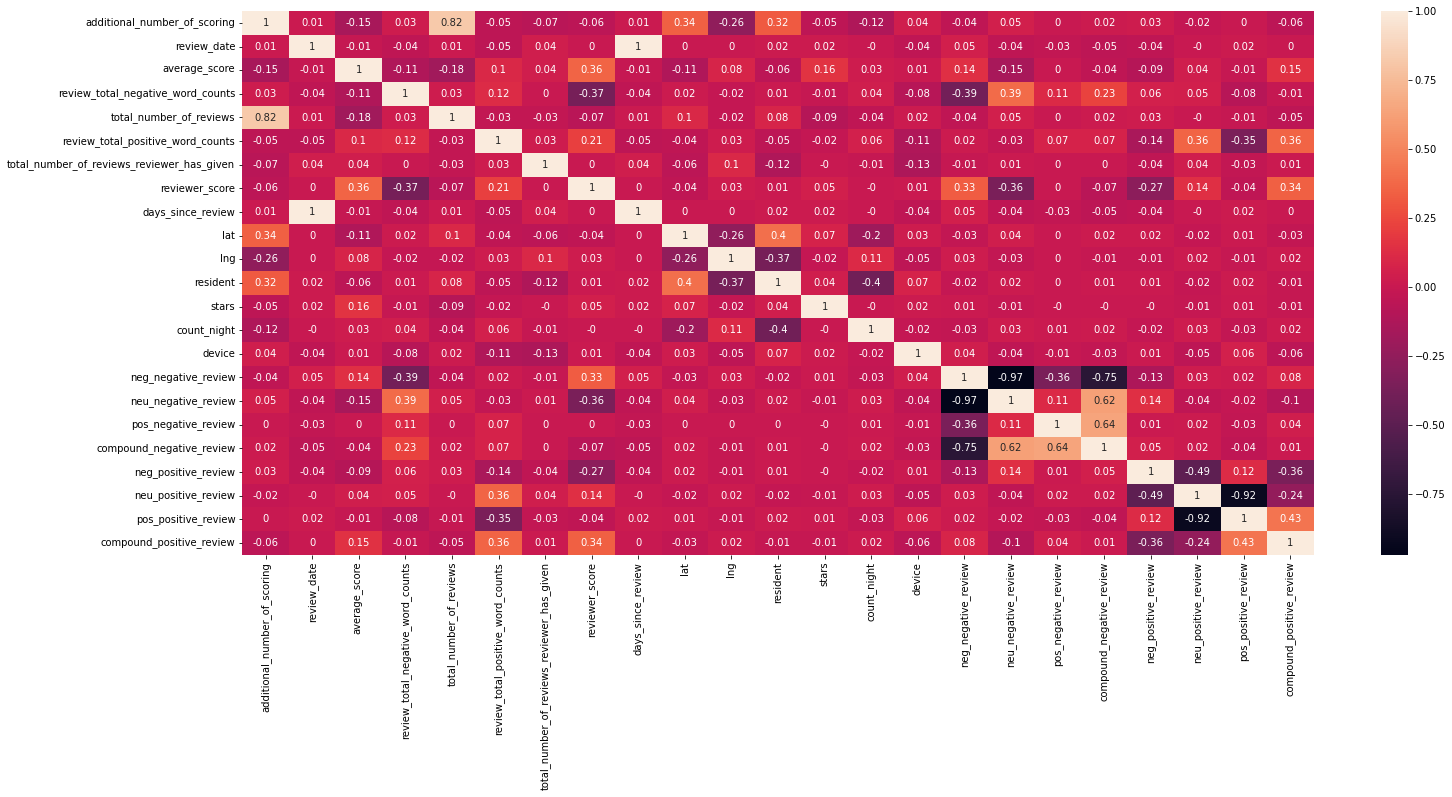

In [38]:
hotels_data_train = pd.read_csv('C:\Python\data\hotels_train.csv')
hotels_train = hotels_data_train.copy()

hotels_data_test = pd.read_csv('C:\Python\data\hotels_test.csv')
hotels_test = hotels_data_test.copy()

sample_submission = pd.read_csv('submission.csv')

# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
hotels_train['sample'] = 1 # помечаем где у нас трейн
hotels_test['sample'] = 0 # помечаем где у нас тест
hotels_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

hotels = pd.concat([hotels_train, hotels_test], axis=0, ignore_index=True)#.reset_index(drop=True) # объединяем

# преобразуем признак review_date в формат datetime
hotels['review_date'] = pd.to_datetime(hotels['review_date'])
# выделим из адреса отеля страну и город и создадим новые признаки
hotels['hotel_address_country'] = hotels['hotel_address'].apply(lambda x: x.split(' ')[-1])
hotels['hotel_address_country'] = hotels['hotel_address_country'].apply(lambda x: 'United Kingdom' if x == 'Kingdom' else x)
hotels['hotel_address_city'] = hotels['hotel_address'].apply(lambda x: x.split(' ')[-5] if x.split(' ')[-1]=='Kingdom' else x.split(' ')[-2] )
# обработаем days_since_review выделив количество дней, преобразуем в числовой признак
hotels['days_since_review'] = hotels['days_since_review'].apply(lambda x: int(x.split(' ')[0]))

# создадим новый бинарный признак из reviewer_nationality и hotel_address_country -  он будет показывать является ли рецензент резидентом данной страны, либо прибыл из других стран
def resident(address_country, nationality):
    """ Возвращает бинарный признак резидентности рецензента
    1 - резидент, 0 - нерезидент
    Args:
        address_country (object): страна отеля
        nationality (object): страна рецензента
    Returns:
        norm: int64
    """
    nationality = nationality.split(' ')
    
    if nationality[-2]=='Kingdom':
        nationality = ''.join([nationality[1], ' ', nationality[2]])
        if address_country == nationality:
            return 1
        else:
            return 0
    else:
        if address_country == nationality[1]:
            return 1
        else:
            return 0
hotels['resident'] = hotels.apply(lambda x: resident(x.hotel_address_country, x.reviewer_nationality), axis=1)    


# составляем словари, где ключи название городов, значения - средние значение координаты по городу
city_lat = dict(hotels.groupby(['hotel_address_city'])['lat'].mean())
city_lng = dict(hotels.groupby(['hotel_address_city'])['lng'].mean())

def change(city, coordinate):
    """Заменяет пропуски в координате и возвращает 
    среднее значение координаты по конкретному городу

    Args:
        city (object): город, где находится гостиница
        coordinate (float64): соответствующая координата -  lat(широта) или lng(длина)

    Returns:
        float64: среднее значение координаты по городу
    """
    if str(coordinate) == 'nan':
        coordinate = city_lat[city]
        return coordinate
    else:
        return coordinate
    
# заполняем пропуски
hotels['lat'] = hotels.apply(lambda x: change(x.hotel_address_city, x.lat), axis=1)
hotels['lng'] = hotels.apply(lambda x: change(x.hotel_address_city, x.lng), axis=1)

# создаём новый признак 'hotels_name_full' с наименование отеля и адрессом
hotels['hotels_name_full'] = hotels['hotel_name'] + ' ' + (hotels['hotel_address'])

# загрузить уже готовый словарь, ранее спарсенный
stars_dict = np.load('stars_dict.npy', allow_pickle=True).item()

def get_stars_hotels(hotels_name_full, stars_dict):
    """ Возвращает информацию о звёздности отеля

    Args:
        hotels_name_full (object_): наименование отеля с адресом
        stars_dict (dictionary): словарь справочник с данными(ключ - наименование отеля, 
        значение - звёздность отеля)

    Returns:
        int: количество звёзд отеля
    """
    star_list = ['1', '2', '3', '4', '5']
    if hotels_name_full in stars_dict.keys():
        star = stars_dict[hotels_name_full]
        if star in star_list:
            star = int(star)
            return star
        else:
            return 0
    else:
        return 0       


# создаём новый признак звёздости в датасете
hotels['stars'] = hotels.apply(lambda x: get_stars_hotels(x.hotels_name_full, stars_dict), axis=1)

hotels['stars'] = hotels['stars'].apply(lambda x: 4 if x == 0 else x)

def tags_info(tags):
    """Обрабатывает признак преобразуя из строкового значения в лист
    удаляя ненужных символы

    Args:
        tags (object): строка с набором тэгов

    Returns:
        object: лист с разделёнными тэгами и очищенный от ненужных символов
    """
    number = ['0', '1,' '2', '3', '4', '5', '6', '7', '8', '9', '0']
    for mot in tags:
        if mot.isalpha() is False and mot != ' ' and mot != ',' and mot not in number:
            tags = tags.replace(mot, '')
    tags = tags.split(',')
    return tags

hotels['tags'] = hotels['tags'].apply(tags_info)

# цель поездки
hotels['purpose of the trip'] = hotels['tags'].apply(lambda x: x[0].strip(' '))
# останавливается один или нет
hotels['form of recreation'] = hotels['tags'].apply(lambda x: x[1].strip(' ') if len(x)>2 else 0)
# категория номера
hotels['room category'] = hotels['tags'].apply(lambda x: x[2].strip(' ') if len(x)>3 else 0)
# количество ночей
hotels['count_night'] = hotels['tags'].apply(lambda x: x[3].strip(' ') if len(x)>=4 else 0)
# дообработка признаков
hotels['purpose of the trip'] = hotels['purpose of the trip'].apply(lambda x: x if x in ['Leisure trip', 'Business trip'] else 'Leisure trip')
hotels['form of recreation'] = hotels['form of recreation'].apply(lambda x: x if x in ['Couple', 'Solo traveler', 'Group', 'Family with young children', 'Family with older children', 'Travelers with friends']
                                                                  else 'Couple')
hotels['room category'] = hotels['room category'].apply(lambda x: 'Double Room' if x ==0 else x)

dict_room = {}
def get_room(room):
    """счётчик категорий по данному признаку, 
    формирует словарь категория:кол-во

    Args:
        room (any): категория
    """
    n = 1
    if room not in dict_room.keys():
        dict_room.update({room:n})
    else:
        dict_room[room] = dict_room[room]+1
# считаем количество категорий по признаку room category, данные сохранены в словарь dict_room
hotels['room category'].apply(get_room)
# в признаке room category, если признак встречается редко(<1000), то заменяем на 'other'    
hotels['room category'] = hotels['room category'].apply(lambda x: x if dict_room[x]>1000 else 'other')


night = {'Stayed  night': 1, 'Stayed  nights': 2, 'Stayed 3 nights': 3, 'Stayed 4 nights': 4, 'Stayed 5 nights': 5,
         'Stayed 6 nights' : 6, 'Stayed 7 nights' : 7, 'Stayed 8 nights': 8, 'Stayed 9 nights' : 9}
hotels['count_night'] = hotels['count_night'].apply(lambda x: night[x] if x in night.keys() else 1)
# создаём признак device показывающий через какое устройство был оставлен отзыв и обрабатываем
hotels['device'] = hotels['tags'].apply(lambda x: x[-1].strip(' '))
hotels['device']= hotels['device'].apply(lambda x: x if x == 'Submitted from a mobile device' else 'Computer')
hotels['device'] = hotels['device'].apply(lambda x:1 if x == 'Submitted from a mobile device' else 0)
# обработаем признак review_date как период, отражающий кол-во дней - разницы между сегодняшним днём и даты отзыва
today = date.today()
hotels['review_date'] = (pd.to_datetime(today) - hotels['review_date']).dt.days

hotels['negative_review'] = hotels['negative_review'].apply(lambda x: 'No Negative' if x == ' ' else x)
hotels['positive_review'] = hotels['positive_review'].apply(lambda x: 'No Positive' if x == ' ' else x)
hotels['review_total_negative_word_counts'] = hotels['negative_review'].apply(lambda x:len(x.split()))
hotels['review_total_positive_word_counts'] = hotels['positive_review'].apply(lambda x:len(x.split()))

def handler_review(review, total_word, type):
    """ Обрабатывает неинформативные короткие(меньше 3 слов) отзывы
    В зависимости от type добавляет в отзыв 'Negative'/'Positive'

    Args:
        review (object_): отзыв
        total_word (int): количество слов в отзыве, 
        type(str): тип отзыва(положительный/ отрицательный)

    Returns:
        review_new/review(object_)): количество звёзд отеля
    """
    if type == 'negative':
        if (total_word < 3) and (review != 'No Negative'):
            review_new = 'Negative'+ ' ' + review
            return review_new
        else:
            return review
    else:
        if (total_word < 3) and (review != 'No Positive'):
            review_new = 'Positive'+ ' ' + review
            return review_new
        else:
            return review
hotels['negative_review'] = hotels.apply(lambda x: handler_review(x.negative_review, x.review_total_negative_word_counts, type='negative'), axis=1)
hotels['positive_review'] = hotels.apply(lambda x: handler_review(x.positive_review, x.review_total_positive_word_counts, type='positive'), axis=1)

hotels['review_total_negative_word_counts'] = hotels['negative_review'].apply(lambda x:len(x.split()))
hotels['review_total_positive_word_counts'] = hotels['positive_review'].apply(lambda x:len(x.split()))

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time
nltk.downloader.download('vader_lexicon')
sent_analyzer = SentimentIntensityAnalyzer()

def nltk_rewiew(rewiew):
    """Анализатор чувств 

    Args:
        rewiew (object): строка с отзывом

    Returns:
        dict: словарь, где ключами являются 'neg'(негативный),
        'neu'(нейтральный), 'pos'(позитивный), 'compound'(оценивает эмоции), а значениями являются: 
        Первые три представляют процент оценок настроений для каждой категории в нашем заголовке, а 'compound' - 
        число, которое оценивает эмоции. составной диапазон составляет от -1 (крайне отрицательный) до 1 (крайне положительный)
    """
    rk_rewiew = sent_analyzer.polarity_scores(rewiew)
    return rk_rewiew

# создадим новые признаки анализаторы чувств
hotels['neg_negative_review'] = hotels['negative_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['neg'])
hotels['neu_negative_review'] = hotels['negative_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['neu'])
hotels['pos_negative_review'] = hotels['negative_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['pos'])
hotels['compound_negative_review'] = hotels['negative_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['compound'])

hotels['neg_positive_review'] = hotels['positive_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['neg'])
hotels['neu_positive_review'] = hotels['positive_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['neu'])
hotels['pos_positive_review'] = hotels['positive_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['pos'])
hotels['compound_positive_review'] = hotels['positive_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['compound'])

hotels = hotels.drop(columns=['hotel_address', 'tags', 'positive_review', 'negative_review', 'hotels_name_full', 'hotel_name'], axis=1)

hotels_train_clean = hotels[hotels['sample']==1].drop('sample', axis=1)
hotels_test_clean = hotels[hotels['sample']==0].drop('sample', axis=1)

# строим матрицу корреляции
fig, axes = plt.subplots(figsize=(24, 10))
sns.heatmap(round(hotels_train_clean.corr(), 2), annot = True)

#hotels_train_clean = hotels_train_clean.drop(columns=['additional_number_of_scoring', 'pos_positive_review', 'neg_negative_review'], axis=1)
#hotels_test_clean = hotels_test_clean.drop(columns=['additional_number_of_scoring', 'pos_positive_review', 'neg_negative_review'], axis=1)


# выделим в кадом наборе данных списки с признаками типа 'object' для кодирования и дальнейшего удаления
object_columns_train_clean = [s for s in hotels_train_clean.columns if hotels_train_clean[s].dtypes == 'object']
object_columns_test_clean = [s for s in hotels_test_clean.columns if hotels_test_clean[s].dtypes == 'object']

# для кодирования используем бинарное кодирование
bin_encoder_train = ce.BinaryEncoder(cols=object_columns_train_clean) # указываем столбцы для кодирования тренировочной выборки
type_bin_train = bin_encoder_train.fit_transform(hotels_train_clean[object_columns_train_clean])
hotels_train_clean = pd.concat([hotels_train_clean, type_bin_train], axis=1)
# кодирование данных тестовой выборки
bin_encoder_test = ce.BinaryEncoder(cols=object_columns_test_clean) # указываем столбцы для кодирования тестовой выборки
type_bin_test = bin_encoder_test.fit_transform(hotels_test_clean[object_columns_test_clean])
hotels_test_clean = pd.concat([hotels_test_clean, type_bin_test], axis=1)
# удаляем лишние признаки
hotels_train_clean = hotels_train_clean.drop(object_columns_train_clean, axis=1)
hotels_test_clean = hotels_test_clean.drop(object_columns_test_clean, axis=1)
hotels_test_clean = hotels_test_clean.drop('reviewer_score', axis=1)


# производим нормализацию данных
X = hotels_train_clean.drop(['reviewer_score'], axis = 1)
y = hotels_train_clean['reviewer_score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
# инициализируем нормализатор MinMaxScaler
mm_scaler = preprocessing.MinMaxScaler()
mm_scaler.fit(X_train)
X_train = mm_scaler.transform(X_train)
X_test = mm_scaler.transform(X_test)

hotels_test_clean_stand = mm_scaler.transform(hotels_test_clean)

# Импортируем необходимые библиотеки:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  
  
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100, random_state=42)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)
# предсказания рейтинга для сабмита
y_pred_test = regr.predict(hotels_test_clean_stand)

# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print(f'MAPE:{metrics.mean_absolute_percentage_error(y_test, y_pred):.3f}')

sample_submission['reviewer_score'] = y_pred_test
sample_submission.to_csv('9_submission.csv', index=False)

Сабмишен Score: 12,64621

### Вариант пятый

Вариант 4 + без handler_review

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Антон\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


MAPE:0.125


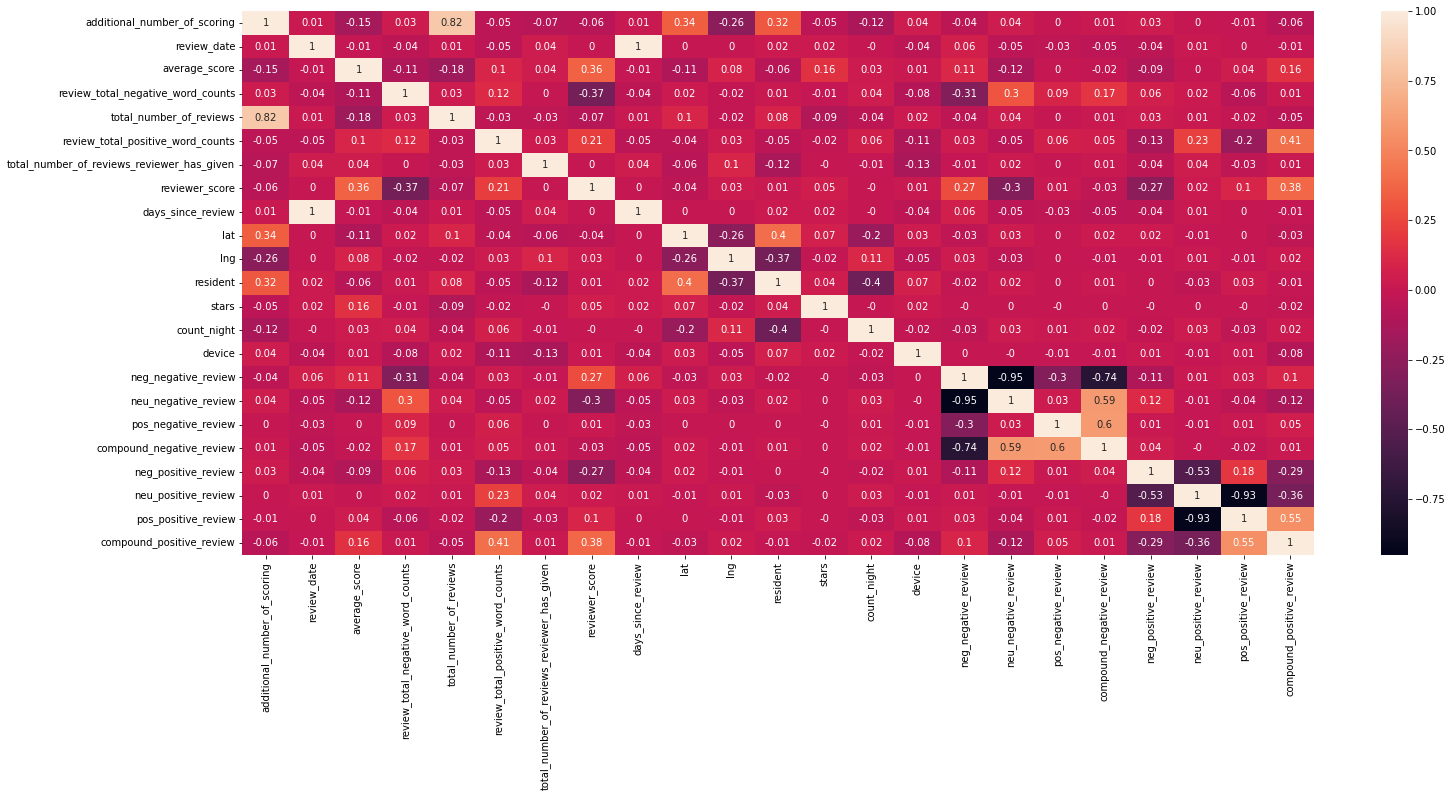

In [39]:
hotels_data_train = pd.read_csv('C:\Python\data\hotels_train.csv')
hotels_train = hotels_data_train.copy()

hotels_data_test = pd.read_csv('C:\Python\data\hotels_test.csv')
hotels_test = hotels_data_test.copy()

sample_submission = pd.read_csv('submission.csv')

# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
hotels_train['sample'] = 1 # помечаем где у нас трейн
hotels_test['sample'] = 0 # помечаем где у нас тест
hotels_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

hotels = pd.concat([hotels_train, hotels_test], axis=0, ignore_index=True)#.reset_index(drop=True) # объединяем

# преобразуем признак review_date в формат datetime
hotels['review_date'] = pd.to_datetime(hotels['review_date'])
# выделим из адреса отеля страну и город и создадим новые признаки
hotels['hotel_address_country'] = hotels['hotel_address'].apply(lambda x: x.split(' ')[-1])
hotels['hotel_address_country'] = hotels['hotel_address_country'].apply(lambda x: 'United Kingdom' if x == 'Kingdom' else x)
hotels['hotel_address_city'] = hotels['hotel_address'].apply(lambda x: x.split(' ')[-5] if x.split(' ')[-1]=='Kingdom' else x.split(' ')[-2] )
# обработаем days_since_review выделив количество дней, преобразуем в числовой признак
hotels['days_since_review'] = hotels['days_since_review'].apply(lambda x: int(x.split(' ')[0]))

# создадим новый бинарный признак из reviewer_nationality и hotel_address_country -  он будет показывать является ли рецензент резидентом данной страны, либо прибыл из других стран
def resident(address_country, nationality):
    """ Возвращает бинарный признак резидентности рецензента
    1 - резидент, 0 - нерезидент
    Args:
        address_country (object): страна отеля
        nationality (object): страна рецензента
    Returns:
        norm: int64
    """
    nationality = nationality.split(' ')
    
    if nationality[-2]=='Kingdom':
        nationality = ''.join([nationality[1], ' ', nationality[2]])
        if address_country == nationality:
            return 1
        else:
            return 0
    else:
        if address_country == nationality[1]:
            return 1
        else:
            return 0
hotels['resident'] = hotels.apply(lambda x: resident(x.hotel_address_country, x.reviewer_nationality), axis=1)    


# составляем словари, где ключи название городов, значения - средние значение координаты по городу
city_lat = dict(hotels.groupby(['hotel_address_city'])['lat'].mean())
city_lng = dict(hotels.groupby(['hotel_address_city'])['lng'].mean())

def change(city, coordinate):
    """Заменяет пропуски в координате и возвращает 
    среднее значение координаты по конкретному городу

    Args:
        city (object): город, где находится гостиница
        coordinate (float64): соответствующая координата -  lat(широта) или lng(длина)

    Returns:
        float64: среднее значение координаты по городу
    """
    if str(coordinate) == 'nan':
        coordinate = city_lat[city]
        return coordinate
    else:
        return coordinate
    
# заполняем пропуски
hotels['lat'] = hotels.apply(lambda x: change(x.hotel_address_city, x.lat), axis=1)
hotels['lng'] = hotels.apply(lambda x: change(x.hotel_address_city, x.lng), axis=1)

# создаём новый признак 'hotels_name_full' с наименование отеля и адрессом
hotels['hotels_name_full'] = hotels['hotel_name'] + ' ' + (hotels['hotel_address'])

# загрузить уже готовый словарь, ранее спарсенный
stars_dict = np.load('stars_dict.npy', allow_pickle=True).item()

def get_stars_hotels(hotels_name_full, stars_dict):
    """ Возвращает информацию о звёздности отеля

    Args:
        hotels_name_full (object_): наименование отеля с адресом
        stars_dict (dictionary): словарь справочник с данными(ключ - наименование отеля, 
        значение - звёздность отеля)

    Returns:
        int: количество звёзд отеля
    """
    star_list = ['1', '2', '3', '4', '5']
    if hotels_name_full in stars_dict.keys():
        star = stars_dict[hotels_name_full]
        if star in star_list:
            star = int(star)
            return star
        else:
            return 0
    else:
        return 0       


# создаём новый признак звёздости в датасете
hotels['stars'] = hotels.apply(lambda x: get_stars_hotels(x.hotels_name_full, stars_dict), axis=1)

hotels['stars'] = hotels['stars'].apply(lambda x: 4 if x == 0 else x)

def tags_info(tags):
    """Обрабатывает признак преобразуя из строкового значения в лист
    удаляя ненужных символы

    Args:
        tags (object): строка с набором тэгов

    Returns:
        object: лист с разделёнными тэгами и очищенный от ненужных символов
    """
    number = ['0', '1,' '2', '3', '4', '5', '6', '7', '8', '9', '0']
    for mot in tags:
        if mot.isalpha() is False and mot != ' ' and mot != ',' and mot not in number:
            tags = tags.replace(mot, '')
    tags = tags.split(',')
    return tags

hotels['tags'] = hotels['tags'].apply(tags_info)

# цель поездки
hotels['purpose of the trip'] = hotels['tags'].apply(lambda x: x[0].strip(' '))
# останавливается один или нет
hotels['form of recreation'] = hotels['tags'].apply(lambda x: x[1].strip(' ') if len(x)>2 else 0)
# категория номера
hotels['room category'] = hotels['tags'].apply(lambda x: x[2].strip(' ') if len(x)>3 else 0)
# количество ночей
hotels['count_night'] = hotels['tags'].apply(lambda x: x[3].strip(' ') if len(x)>=4 else 0)
# дообработка признаков
hotels['purpose of the trip'] = hotels['purpose of the trip'].apply(lambda x: x if x in ['Leisure trip', 'Business trip'] else 'Leisure trip')
hotels['form of recreation'] = hotels['form of recreation'].apply(lambda x: x if x in ['Couple', 'Solo traveler', 'Group', 'Family with young children', 'Family with older children', 'Travelers with friends']
                                                                  else 'Couple')
hotels['room category'] = hotels['room category'].apply(lambda x: 'Double Room' if x ==0 else x)

dict_room = {}
def get_room(room):
    """счётчик категорий по данному признаку, 
    формирует словарь категория:кол-во

    Args:
        room (any): категория
    """
    n = 1
    if room not in dict_room.keys():
        dict_room.update({room:n})
    else:
        dict_room[room] = dict_room[room]+1
# считаем количество категорий по признаку room category, данные сохранены в словарь dict_room
hotels['room category'].apply(get_room)
# в признаке room category, если признак встречается редко(<1000), то заменяем на 'other'    
hotels['room category'] = hotels['room category'].apply(lambda x: x if dict_room[x]>1000 else 'other')


night = {'Stayed  night': 1, 'Stayed  nights': 2, 'Stayed 3 nights': 3, 'Stayed 4 nights': 4, 'Stayed 5 nights': 5,
         'Stayed 6 nights' : 6, 'Stayed 7 nights' : 7, 'Stayed 8 nights': 8, 'Stayed 9 nights' : 9}
hotels['count_night'] = hotels['count_night'].apply(lambda x: night[x] if x in night.keys() else 1)
# создаём признак device показывающий через какое устройство был оставлен отзыв и обрабатываем
hotels['device'] = hotels['tags'].apply(lambda x: x[-1].strip(' '))
hotels['device']= hotels['device'].apply(lambda x: x if x == 'Submitted from a mobile device' else 'Computer')
hotels['device'] = hotels['device'].apply(lambda x:1 if x == 'Submitted from a mobile device' else 0)
# обработаем признак review_date как период, отражающий кол-во дней - разницы между сегодняшним днём и даты отзыва
today = date.today()
hotels['review_date'] = (pd.to_datetime(today) - hotels['review_date']).dt.days

hotels['negative_review'] = hotels['negative_review'].apply(lambda x: 'No Negative' if x == ' ' else x)
hotels['positive_review'] = hotels['positive_review'].apply(lambda x: 'No Positive' if x == ' ' else x)
hotels['review_total_negative_word_counts'] = hotels['negative_review'].apply(lambda x:len(x.split()))
hotels['review_total_positive_word_counts'] = hotels['positive_review'].apply(lambda x:len(x.split()))

def handler_review(review, total_word, type):
    """ Обрабатывает неинформативные короткие(меньше 3 слов) отзывы
    В зависимости от type добавляет в отзыв 'Negative'/'Positive'

    Args:
        review (object_): отзыв
        total_word (int): количество слов в отзыве, 
        type(str): тип отзыва(положительный/ отрицательный)

    Returns:
        review_new/review(object_)): новый отзыв
    """
    if type == 'negative':
        if total_word < 3:
            review_new = 'Negative'+ ' ' + review
            return review_new
        else:
            return review
    else:
        if total_word < 3:
            review_new = 'Positive'+ ' ' + review
            return review_new
        else:
            return review
""" hotels['negative_review'] = hotels.apply(lambda x: handler_review(x.negative_review, x.review_total_negative_word_counts, type='negative'), axis=1)
hotels['positive_review'] = hotels.apply(lambda x: handler_review(x.positive_review, x.review_total_positive_word_counts, type='positive'), axis=1)

hotels['review_total_negative_word_counts'] = hotels['negative_review'].apply(lambda x:len(x.split()))
hotels['review_total_positive_word_counts'] = hotels['positive_review'].apply(lambda x:len(x.split())) """

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time
nltk.downloader.download('vader_lexicon')
sent_analyzer = SentimentIntensityAnalyzer()

def nltk_rewiew(rewiew):
    """Анализатор чувств 

    Args:
        rewiew (object): строка с отзывом

    Returns:
        dict: словарь, где ключами являются 'neg'(негативный),
        'neu'(нейтральный), 'pos'(позитивный), 'compound'(оценивает эмоции), а значениями являются: 
        Первые три представляют процент оценок настроений для каждой категории в нашем заголовке, а 'compound' - 
        число, которое оценивает эмоции. составной диапазон составляет от -1 (крайне отрицательный) до 1 (крайне положительный)
    """
    rk_rewiew = sent_analyzer.polarity_scores(rewiew)
    return rk_rewiew

# создадим новые признаки анализаторы чувств
hotels['neg_negative_review'] = hotels['negative_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['neg'])
hotels['neu_negative_review'] = hotels['negative_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['neu'])
hotels['pos_negative_review'] = hotels['negative_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['pos'])
hotels['compound_negative_review'] = hotels['negative_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['compound'])

hotels['neg_positive_review'] = hotels['positive_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['neg'])
hotels['neu_positive_review'] = hotels['positive_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['neu'])
hotels['pos_positive_review'] = hotels['positive_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['pos'])
hotels['compound_positive_review'] = hotels['positive_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['compound'])

hotels = hotels.drop(columns=['hotel_address', 'tags', 'positive_review', 'negative_review', 'hotels_name_full', 'hotel_name'], axis=1)

hotels_train_clean = hotels[hotels['sample']==1].drop('sample', axis=1)
hotels_test_clean = hotels[hotels['sample']==0].drop('sample', axis=1)

# строим матрицу корреляции
fig, axes = plt.subplots(figsize=(24, 10))
sns.heatmap(round(hotels_train_clean.corr(), 2), annot = True)

#hotels_train_clean = hotels_train_clean.drop(columns=['additional_number_of_scoring', 'pos_positive_review', 'neg_negative_review'], axis=1)
#hotels_test_clean = hotels_test_clean.drop(columns=['additional_number_of_scoring', 'pos_positive_review', 'neg_negative_review'], axis=1)


# выделим в кадом наборе данных списки с признаками типа 'object' для кодирования и дальнейшего удаления
object_columns_train_clean = [s for s in hotels_train_clean.columns if hotels_train_clean[s].dtypes == 'object']
object_columns_test_clean = [s for s in hotels_test_clean.columns if hotels_test_clean[s].dtypes == 'object']

# для кодирования используем бинарное кодирование
bin_encoder_train = ce.BinaryEncoder(cols=object_columns_train_clean) # указываем столбцы для кодирования тренировочной выборки
type_bin_train = bin_encoder_train.fit_transform(hotels_train_clean[object_columns_train_clean])
hotels_train_clean = pd.concat([hotels_train_clean, type_bin_train], axis=1)
# кодирование данных тестовой выборки
bin_encoder_test = ce.BinaryEncoder(cols=object_columns_test_clean) # указываем столбцы для кодирования тестовой выборки
type_bin_test = bin_encoder_test.fit_transform(hotels_test_clean[object_columns_test_clean])
hotels_test_clean = pd.concat([hotels_test_clean, type_bin_test], axis=1)
# удаляем лишние признаки
hotels_train_clean = hotels_train_clean.drop(object_columns_train_clean, axis=1)
hotels_test_clean = hotels_test_clean.drop(object_columns_test_clean, axis=1)
hotels_test_clean = hotels_test_clean.drop('reviewer_score', axis=1)


# производим нормализацию данных
X = hotels_train_clean.drop(['reviewer_score'], axis = 1)
y = hotels_train_clean['reviewer_score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
# инициализируем нормализатор MinMaxScaler
mm_scaler = preprocessing.MinMaxScaler()
mm_scaler.fit(X_train)
X_train = mm_scaler.transform(X_train)
X_test = mm_scaler.transform(X_test)

hotels_test_clean_stand = mm_scaler.transform(hotels_test_clean)

# Импортируем необходимые библиотеки:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  
  
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)
# предсказания рейтинга для сабмита
y_pred_test = regr.predict(hotels_test_clean_stand)

# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print(f'MAPE:{metrics.mean_absolute_percentage_error(y_test, y_pred):.3f}')

sample_submission['reviewer_score'] = y_pred_test
sample_submission.to_csv('10_submission.csv', index=False)

Оценка сабмишена Score: 12.62182

### Вариант 6

**handler_review** не задействуем, но заменим 'negative_review'/'positive_review' на 'No/Yes'


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Антон\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


MAPE:0.125


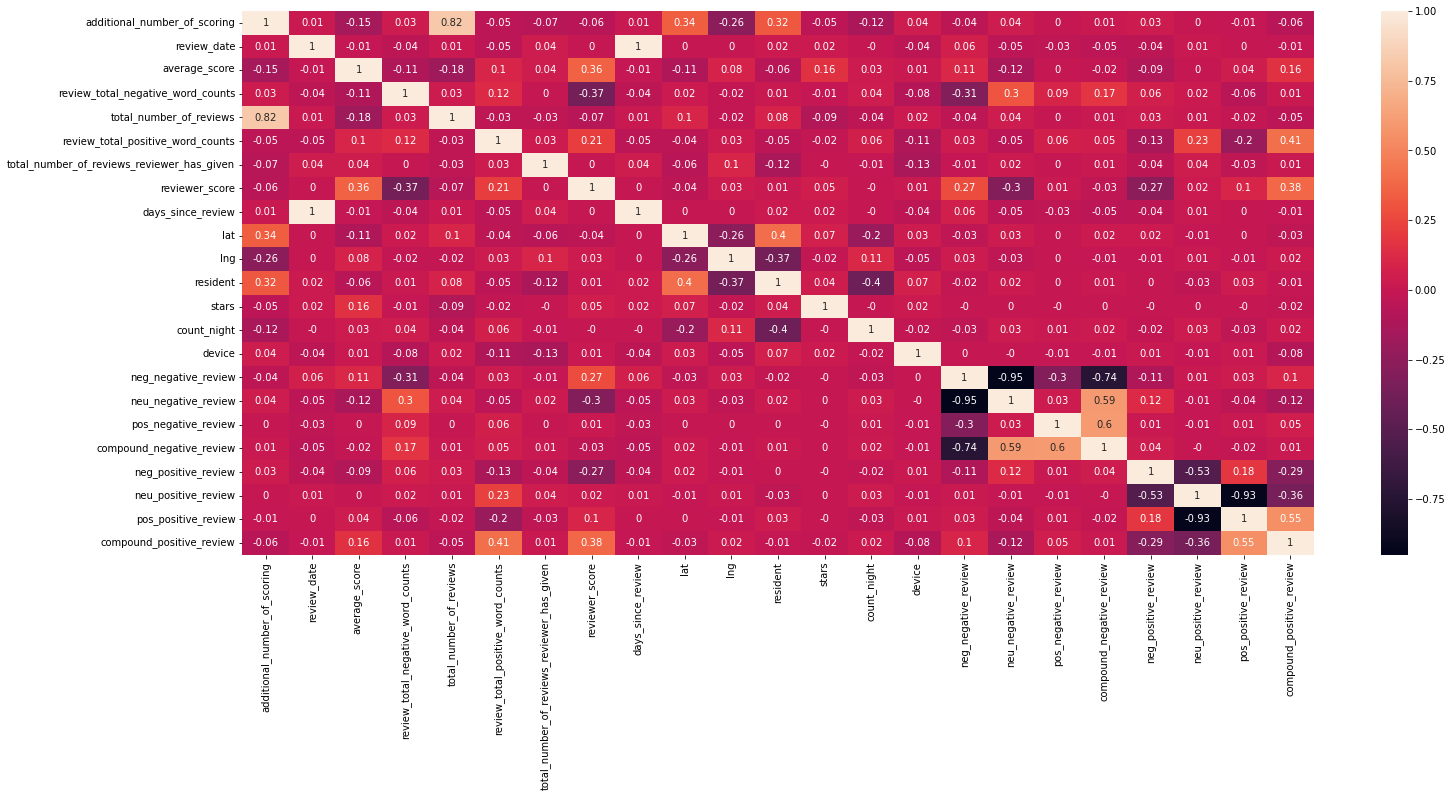

In [52]:
hotels_data_train = pd.read_csv('C:\Python\data\hotels_train.csv')
hotels_train = hotels_data_train.copy()

hotels_data_test = pd.read_csv('C:\Python\data\hotels_test.csv')
hotels_test = hotels_data_test.copy()

sample_submission = pd.read_csv('submission.csv')

# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
hotels_train['sample'] = 1 # помечаем где у нас трейн
hotels_test['sample'] = 0 # помечаем где у нас тест
hotels_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

hotels = pd.concat([hotels_train, hotels_test], axis=0, ignore_index=True)#.reset_index(drop=True) # объединяем

# преобразуем признак review_date в формат datetime
hotels['review_date'] = pd.to_datetime(hotels['review_date'])
# выделим из адреса отеля страну и город и создадим новые признаки
hotels['hotel_address_country'] = hotels['hotel_address'].apply(lambda x: x.split(' ')[-1])
hotels['hotel_address_country'] = hotels['hotel_address_country'].apply(lambda x: 'United Kingdom' if x == 'Kingdom' else x)
hotels['hotel_address_city'] = hotels['hotel_address'].apply(lambda x: x.split(' ')[-5] if x.split(' ')[-1]=='Kingdom' else x.split(' ')[-2] )
# обработаем days_since_review выделив количество дней, преобразуем в числовой признак
hotels['days_since_review'] = hotels['days_since_review'].apply(lambda x: int(x.split(' ')[0]))

# создадим новый бинарный признак из reviewer_nationality и hotel_address_country -  он будет показывать является ли рецензент резидентом данной страны, либо прибыл из других стран
def resident(address_country, nationality):
    """ Возвращает бинарный признак резидентности рецензента
    1 - резидент, 0 - нерезидент
    Args:
        address_country (object): страна отеля
        nationality (object): страна рецензента
    Returns:
        norm: int64
    """
    nationality = nationality.split(' ')
    
    if nationality[-2]=='Kingdom':
        nationality = ''.join([nationality[1], ' ', nationality[2]])
        if address_country == nationality:
            return 1
        else:
            return 0
    else:
        if address_country == nationality[1]:
            return 1
        else:
            return 0
hotels['resident'] = hotels.apply(lambda x: resident(x.hotel_address_country, x.reviewer_nationality), axis=1)    


# составляем словари, где ключи название городов, значения - средние значение координаты по городу
city_lat = dict(hotels.groupby(['hotel_address_city'])['lat'].mean())
city_lng = dict(hotels.groupby(['hotel_address_city'])['lng'].mean())

def change(city, coordinate):
    """Заменяет пропуски в координате и возвращает 
    среднее значение координаты по конкретному городу

    Args:
        city (object): город, где находится гостиница
        coordinate (float64): соответствующая координата -  lat(широта) или lng(длина)

    Returns:
        float64: среднее значение координаты по городу
    """
    if str(coordinate) == 'nan':
        coordinate = city_lat[city]
        return coordinate
    else:
        return coordinate
    
# заполняем пропуски
hotels['lat'] = hotels.apply(lambda x: change(x.hotel_address_city, x.lat), axis=1)
hotels['lng'] = hotels.apply(lambda x: change(x.hotel_address_city, x.lng), axis=1)

# создаём новый признак 'hotels_name_full' с наименование отеля и адрессом
hotels['hotels_name_full'] = hotels['hotel_name'] + ' ' + (hotels['hotel_address'])

# загрузить уже готовый словарь, ранее спарсенный
stars_dict = np.load('stars_dict.npy', allow_pickle=True).item()

def get_stars_hotels(hotels_name_full, stars_dict):
    """ Возвращает информацию о звёздности отеля

    Args:
        hotels_name_full (object_): наименование отеля с адресом
        stars_dict (dictionary): словарь справочник с данными(ключ - наименование отеля, 
        значение - звёздность отеля)

    Returns:
        int: количество звёзд отеля
    """
    star_list = ['1', '2', '3', '4', '5']
    if hotels_name_full in stars_dict.keys():
        star = stars_dict[hotels_name_full]
        if star in star_list:
            star = int(star)
            return star
        else:
            return 0
    else:
        return 0       


# создаём новый признак звёздости в датасете
hotels['stars'] = hotels.apply(lambda x: get_stars_hotels(x.hotels_name_full, stars_dict), axis=1)

hotels['stars'] = hotels['stars'].apply(lambda x: 4 if x == 0 else x)

def tags_info(tags):
    """Обрабатывает признак преобразуя из строкового значения в лист
    удаляя ненужных символы

    Args:
        tags (object): строка с набором тэгов

    Returns:
        object: лист с разделёнными тэгами и очищенный от ненужных символов
    """
    number = ['0', '1,' '2', '3', '4', '5', '6', '7', '8', '9', '0']
    for mot in tags:
        if mot.isalpha() is False and mot != ' ' and mot != ',' and mot not in number:
            tags = tags.replace(mot, '')
    tags = tags.split(',')
    return tags

hotels['tags'] = hotels['tags'].apply(tags_info)

# цель поездки
hotels['purpose of the trip'] = hotels['tags'].apply(lambda x: x[0].strip(' '))
# останавливается один или нет
hotels['form of recreation'] = hotels['tags'].apply(lambda x: x[1].strip(' ') if len(x)>2 else 0)
# категория номера
hotels['room category'] = hotels['tags'].apply(lambda x: x[2].strip(' ') if len(x)>3 else 0)
# количество ночей
hotels['count_night'] = hotels['tags'].apply(lambda x: x[3].strip(' ') if len(x)>=4 else 0)
# дообработка признаков
hotels['purpose of the trip'] = hotels['purpose of the trip'].apply(lambda x: x if x in ['Leisure trip', 'Business trip'] else 'Leisure trip')
hotels['form of recreation'] = hotels['form of recreation'].apply(lambda x: x if x in ['Couple', 'Solo traveler', 'Group', 'Family with young children', 'Family with older children', 'Travelers with friends']
                                                                  else 'Couple')
hotels['room category'] = hotels['room category'].apply(lambda x: 'Double Room' if x ==0 else x)

dict_room = {}
def get_room(room):
    """счётчик категорий по данному признаку, 
    формирует словарь категория:кол-во

    Args:
        room (any): категория
    """
    n = 1
    if room not in dict_room.keys():
        dict_room.update({room:n})
    else:
        dict_room[room] = dict_room[room]+1
# считаем количество категорий по признаку room category, данные сохранены в словарь dict_room
hotels['room category'].apply(get_room)
# в признаке room category, если признак встречается редко(<1000), то заменяем на 'other'    
hotels['room category'] = hotels['room category'].apply(lambda x: x if dict_room[x]>1000 else 'other')


night = {'Stayed  night': 1, 'Stayed  nights': 2, 'Stayed 3 nights': 3, 'Stayed 4 nights': 4, 'Stayed 5 nights': 5,
         'Stayed 6 nights' : 6, 'Stayed 7 nights' : 7, 'Stayed 8 nights': 8, 'Stayed 9 nights' : 9}
hotels['count_night'] = hotels['count_night'].apply(lambda x: night[x] if x in night.keys() else 1)
# создаём признак device показывающий через какое устройство был оставлен отзыв и обрабатываем
hotels['device'] = hotels['tags'].apply(lambda x: x[-1].strip(' '))
hotels['device']= hotels['device'].apply(lambda x: x if x == 'Submitted from a mobile device' else 'Computer')
hotels['device'] = hotels['device'].apply(lambda x:1 if x == 'Submitted from a mobile device' else 0)
# обработаем признак review_date как период, отражающий кол-во дней - разницы между сегодняшним днём и даты отзыва
today = date.today()
hotels['review_date'] = (pd.to_datetime(today) - hotels['review_date']).dt.days

hotels['negative_review'] = hotels['negative_review'].apply(lambda x: 'No' if x == ' ' else x)
hotels['positive_review'] = hotels['positive_review'].apply(lambda x: 'Yes' if x == ' ' else x)
hotels['review_total_negative_word_counts'] = hotels['negative_review'].apply(lambda x:len(x.split()))
hotels['review_total_positive_word_counts'] = hotels['positive_review'].apply(lambda x:len(x.split()))

def handler_review(review, total_word, type):
    """ Обрабатывает неинформативные короткие(меньше 3 слов) отзывы
    В зависимости от type добавляет в отзыв 'Negative'/'Positive'

    Args:
        review (object_): отзыв
        total_word (int): количество слов в отзыве, 
        type(str): тип отзыва(положительный/ отрицательный)

    Returns:
        review_new/review(object_)): новый отзыв
    """
    if type == 'negative':
        if (total_word < 3) and (review != 'No Negative') and (review != ' '):
            review_new = 'No'+ ' ' + review
            return review_new
        else:
            return review
    else:
        if (total_word < 3) and (review != 'No Positive') and (review != ' '):
            review_new = 'Yes'+ ' ' + review
            return review_new
        else:
            return review
#hotels['negative_review'] = hotels.apply(lambda x: handler_review(x.negative_review, x.review_total_negative_word_counts, type='negative'), axis=1)
#hotels['positive_review'] = hotels.apply(lambda x: handler_review(x.positive_review, x.review_total_positive_word_counts, type='positive'), axis=1)

hotels['review_total_negative_word_counts'] = hotels['negative_review'].apply(lambda x:len(x.split()))
hotels['review_total_positive_word_counts'] = hotels['positive_review'].apply(lambda x:len(x.split()))

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time
nltk.downloader.download('vader_lexicon')
sent_analyzer = SentimentIntensityAnalyzer()

def nltk_rewiew(rewiew):
    """Анализатор чувств 

    Args:
        rewiew (object): строка с отзывом

    Returns:
        dict: словарь, где ключами являются 'neg'(негативный),
        'neu'(нейтральный), 'pos'(позитивный), 'compound'(оценивает эмоции), а значениями являются: 
        Первые три представляют процент оценок настроений для каждой категории в нашем заголовке, а 'compound' - 
        число, которое оценивает эмоции. составной диапазон составляет от -1 (крайне отрицательный) до 1 (крайне положительный)
    """
    rk_rewiew = sent_analyzer.polarity_scores(rewiew)
    return rk_rewiew

# создадим новые признаки анализаторы чувств
hotels['neg_negative_review'] = hotels['negative_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['neg'])
hotels['neu_negative_review'] = hotels['negative_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['neu'])
hotels['pos_negative_review'] = hotels['negative_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['pos'])
hotels['compound_negative_review'] = hotels['negative_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['compound'])

hotels['neg_positive_review'] = hotels['positive_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['neg'])
hotels['neu_positive_review'] = hotels['positive_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['neu'])
hotels['pos_positive_review'] = hotels['positive_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['pos'])
hotels['compound_positive_review'] = hotels['positive_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['compound'])

hotels = hotels.drop(columns=['hotel_address', 'tags', 'positive_review', 'negative_review', 'hotels_name_full', 'hotel_name'], axis=1)

hotels_train_clean = hotels[hotels['sample']==1].drop('sample', axis=1)
hotels_test_clean = hotels[hotels['sample']==0].drop('sample', axis=1)

# строим матрицу корреляции
fig, axes = plt.subplots(figsize=(24, 10))
sns.heatmap(round(hotels_train_clean.corr(), 2), annot = True)

#hotels_train_clean = hotels_train_clean.drop(columns=['additional_number_of_scoring', 'pos_positive_review', 'neg_negative_review'], axis=1)
#hotels_test_clean = hotels_test_clean.drop(columns=['additional_number_of_scoring', 'pos_positive_review', 'neg_negative_review'], axis=1)


# выделим в кадом наборе данных списки с признаками типа 'object' для кодирования и дальнейшего удаления
object_columns_train_clean = [s for s in hotels_train_clean.columns if hotels_train_clean[s].dtypes == 'object']
object_columns_test_clean = [s for s in hotels_test_clean.columns if hotels_test_clean[s].dtypes == 'object']

# для кодирования используем бинарное кодирование
bin_encoder_train = ce.BinaryEncoder(cols=object_columns_train_clean) # указываем столбцы для кодирования тренировочной выборки
type_bin_train = bin_encoder_train.fit_transform(hotels_train_clean[object_columns_train_clean])
hotels_train_clean = pd.concat([hotels_train_clean, type_bin_train], axis=1)
# кодирование данных тестовой выборки
bin_encoder_test = ce.BinaryEncoder(cols=object_columns_test_clean) # указываем столбцы для кодирования тестовой выборки
type_bin_test = bin_encoder_test.fit_transform(hotels_test_clean[object_columns_test_clean])
hotels_test_clean = pd.concat([hotels_test_clean, type_bin_test], axis=1)
# удаляем лишние признаки
hotels_train_clean = hotels_train_clean.drop(object_columns_train_clean, axis=1)
hotels_test_clean = hotels_test_clean.drop(object_columns_test_clean, axis=1)
hotels_test_clean = hotels_test_clean.drop('reviewer_score', axis=1)


# производим нормализацию данных
X = hotels_train_clean.drop(['reviewer_score'], axis = 1)
y = hotels_train_clean['reviewer_score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
# инициализируем нормализатор MinMaxScaler
mm_scaler = preprocessing.MinMaxScaler()
mm_scaler.fit(X_train)
X_train = mm_scaler.transform(X_train)
X_test = mm_scaler.transform(X_test)

hotels_test_clean_stand = mm_scaler.transform(hotels_test_clean)

# Импортируем необходимые библиотеки:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  
  
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100, random_state=42)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)
# предсказания рейтинга для сабмита
y_pred_test = regr.predict(hotels_test_clean_stand)

# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print(f'MAPE:{metrics.mean_absolute_percentage_error(y_test, y_pred):.3f}')

sample_submission['reviewer_score'] = y_pred_test
sample_submission.to_csv('14_submission.csv', index=False)

Оценка сабмишена Score: 12.62557